In [13]:
spark.stop()

In [1]:
core = 8
nome = "marco"
#nicolò
#marco
#francesco
#raffaele

In [16]:
# Pulizia delle cache (rimuove se ci sono dataframe persistati)

# # FOR DOCKER ---------- DO NOT DELETE
# #df_final_088.write.mode("overwrite").parquet("df_lavorare.parquet") #save file
# df_final_088 = spark.read.parquet("df_lavorare.parquet") #read file
# useful_sensors = ['P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S107', 'S109', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S151', 'S154', 'S157', 'S158', 'S159', 'S164', 'S166', 'S169', 'S170', 'S171', 'S172', 'S173', 'S174', 'S178', 'S179', 'S180', 'S181', 'S183', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S35', 'S37', 'S39', 'S40', 'S41', 'S46', 'S47', 'S5', 'S53', 'S55', 'S6', 'S64', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA2', 'SA3', 'SA5', 'SA6', 'SA7', 'SA9']
# list_hw = ["SW-115","SW-088","SW-065","SW-106"]

#spark.catalog.clearCache()
import gc
gc.collect()

0

In [3]:
# mapping utenti → (SparkUI, user)
mappa = {
    "nicolò":   (4040, "user_a", False),
    "marco":    (4041, "user_b", True),
    "francesco":(4042, "user_c", False),
    "raffaele": (4043, "user_d", False),
}
# recupero SparkUI e user dal mapping
SparkUI, user, docker = mappa[nome]
Npartition = 4*core # Regola generale: numero_partizioni = numero_core * (2 o 4)
Nexecutors = 4

print(f"Hai settato {SparkUI} e {user}: tu sei {nome}")
if docker:
    print(f"STAI USANDO DOCKER")
else:
    print(f"STAI USANDO CLOUDVENETO")

Hai settato 4041 e user_b: tu sei marco
STAI USANDO DOCKER


sudo pkill -u $(whoami) -f "jupyter-notebook"

# Setting Spark Session

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from math import ceil, floor
from functools import reduce
from IPython.display import display, HTML

from pyspark import SparkFiles
from pyspark.sql import SparkSession, DataFrame, Window
from pyspark.sql.types import (
    StructType, StructField, IntegerType, DoubleType, 
    TimestampType, BooleanType
)

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

from pyspark.sql.functions import (
    col, lit, expr, when, coalesce, corr, array, countDistinct, 
    approx_count_distinct, count, count_if, row_number,  sum as spark_sum, abs as spark_abs, sqrt as spark_sqrt,
    round as spark_round, min as spark_min, max as spark_max, avg as spark_avg, stddev as spark_stddev,
    first, last, lag, lead, desc, asc, bool_or, explode, sequence, 
    from_unixtime, to_date, unix_timestamp, array_repeat, window, 
    min_by, mode, concat, monotonically_increasing_id, mean, rand
)

In [5]:
if docker:

    spark = SparkSession.builder \
        .master("spark://spark-master:7077") \
        .appName("ProjectDocker") \
        .config("spark.executor.memory", "1300m") \
        .config("spark.cores.max", "8") \
        .config("spark.default.parallelism", "16") \
        .config("spark.sql.shuffle.partitions", "16") \
        .config("spark.sql.adaptive.enabled", "true") \
        .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
        .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
        .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false") \
        .config("spark.sql.debug.maxToStringFields", 1000) \
        .getOrCreate()

        # SE NON FUNZIONA TOGLI I DUE CONFIG DI ARROW

        # .config("spark.executor.memory", "1500m")
        # .config("spark.executor.cores", "1")\
        # .config("spark.executor.instances", "12")\
        # .config("spark.cores.max", "12")\
        # .config("spark.default.parallelism", "24")\
        # .config("spark.sql.adaptive.enabled", "true")\

else:

    os.environ["PYSPARK_PYTHON"] = "/opt/miniconda3/bin/python"
    os.environ["PYSPARK_DRIVER_PYTHON"] = "/opt/miniconda3/bin/python"
    
    configs = {
        "spark.scheduler.mode": "FAIR",                                  # Multi-user scheduler
        "spark.scheduler.pool": user,                                    # User pool
        "spark.scheduler.allocation.file": "file:///usr/local/spark/conf/fairscheduler.xml",  # Scheduler config file
        "spark.executor.memory": "2200m",                                # Executor RAM
        "spark.cores.max": core,                                         # Total cores
        "spark.executor.instances": Nexecutors,                          # Number of executors
        "spark.sql.shuffle.partitions": Npartition,                      # Shuffle partitions
        "spark.sql.execution.arrow.pyspark.enabled": "true",             # Enable Arrow
        "spark.sql.execution.arrow.pyspark.fallback.enabled": "false",   # No Arrow fallback
        "spark.dynamicAllocation.enabled": "false",                      # No dynamic allocation
        "spark.shuffle.service.enabled": "false",                        # No shuffle service
        "spark.ui.port": SparkUI,                                        # Custom UI port
        "spark.sql.debug.maxToStringFields": 1000                        # Debug fields limit
    }
    
    spark_builder = SparkSession.builder \
       .appName("ProjectCloudVeneto") \
       .master("spark://10.67.22.135:7077")
    
    for key, value in configs.items():
       spark_builder = spark_builder.config(key, value)
    
    spark = spark_builder.getOrCreate()

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/25 09:08:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
sensors = ['P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S106', 'S107', 'S108', 'S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 'S163', 'S164', 'S165', 'S166', 'S167', 'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S180', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW']
alarms = ['A5', 'A9', 'ComError']
engines = ["S117", "S118", "S169", "S170"]
print(f"There are {len(sensors)} sensors.\n")

There are 130 sensors.



In [7]:
def print_separator(hw): 
    return display(HTML(f"<div style='text-align:center; font-size:24px; font-weight:bold; margin:20px 0;'>--------------------------{hw}--------------------------</div>"))

# Upload and inspect dataset

In [16]:
%%time 

df = spark.read.option("header", True).option("inferSchema", True).csv("file:///mnt/shared/dataset.csv").repartition(4, col("hwid"))

# convert milliseconds into seconds
df = df.withColumn("when", spark_round(col("when") / 1000).cast(IntegerType()))

[Stage 8:======================================================>  (37 + 2) / 39]

CPU times: user 16.5 ms, sys: 7.1 ms, total: 23.6 ms
Wall time: 23.1 s


In [17]:
# inspect dataset
df.printSchema()

root
 |-- when: integer (nullable = true)
 |-- hwid: string (nullable = true)
 |-- metric: string (nullable = true)
 |-- value: integer (nullable = true)



In [18]:
# inspect hardwares of dataset
hwid_list = df.select("hwid").distinct()
hwid_list.show()

[Stage 13:======================================>                   (2 + 1) / 3]

+------+
|  hwid|
+------+
|SW-115|
|SW-088|
|SW-065|
|SW-106|
+------+



In [20]:
list_hw = df.select("hwid").distinct().rdd.flatMap(lambda x : x).collect()
list_hw.sort()

In [42]:
%%time

# Process all hardware in parallel with window functions
df_all_hw = (df.groupBy("hwid", "when")
                   .pivot("metric")
                   .agg(first("value"))
                   .withColumn("time", from_unixtime(col("when")))
                   .orderBy("hwid", "when"))

df_all_hw = df_all_hw.persist()
df_all_hw.count()

engines = ["S117", "S118", "S169", "S170"]
df_all_hw.select("when","time",*engines).orderBy(col("time").asc()).show(5)

25/08/24 16:17:37 ERROR TaskSchedulerImpl: Lost executor 2 on 10.67.22.135: Command exited with code 137
25/08/24 16:17:37 WARN TaskSetManager: Lost task 0.0 in stage 1112.0 (TID 1496) (10.67.22.135 executor 2): ExecutorLostFailure (executor 2 exited caused by one of the running tasks) Reason: Command exited with code 137
25/08/24 16:17:37 WARN TaskSetManager: Lost task 0.1 in stage 1112.0 (TID 1498) (10.67.22.228 executor 1): FetchFailed(null, shuffleId=242, mapIndex=-1, mapId=-1, reduceId=0, message=
org.apache.spark.shuffle.MetadataFetchFailedException: Missing an output location for shuffle 242 partition 0
	at org.apache.spark.MapOutputTracker$.validateStatus(MapOutputTracker.scala:1747)
	at org.apache.spark.MapOutputTracker$.$anonfun$convertMapStatuses$11(MapOutputTracker.scala:1694)
	at org.apache.spark.MapOutputTracker$.$anonfun$convertMapStatuses$11$adapted(MapOutputTracker.scala:1693)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.forea

KeyboardInterrupt: 

In [ ]:
%%time
#Reformat the data with the correct decimal

decimals = {'P5': 1, 'P6': 1, 'P7': 1, 'P8': 1, 'P9': 1, 'P10': 1, 'P16': 1, 'P17': 1, 'P18': 1, 'S3': 1, 'S6': 1, 'S19': 1, 'S37': 1, 'S39': 1, 'S40': 1, 'S41': 1,'S42': 1, 'S43': 1, 'S45': 1, 'S46': 1, 'S47': 1, 'S49': 1, 'S50': 1, 'S69': 1, 'S70': 1, 'S71': 1, 'S72': 1, 'S80': 1, 'S81': 1, 'S83': 1, 'S97': 1, 'S100': 1, 'S101': 1, 'S102': 1, 'S106': 1, 'S107': 1, 'S108': 1, 'S109': 1, 'S110': 1, 'S122': 2, 'S124': 1, 'S126': 1, 'S128': 1, 'S129': 1, 'S137': 1, 'S138': 1, 'S140': 1, 'S154': 1, 'S157': 1, 'S158': 1, 'S159': 1, 'S163': 1, 'S164': 1, 'S165': 1, 'S166': 1, 'S167': 1, 'S178': 2, 'S180': 1}

columns_to_transform = [(col(c) / (10**decimals[c])).alias(c) if c in decimals else col(c) for c in df_all_hw.columns]
df_all_hw = df_all_hw.select(*columns_to_transform)

In [ ]:
df_all_hw.select("when",*engines).show(10)

# Timestamp analysis

In [ ]:
def compute_time_differences(df):
    w = Window.partitionBy("hwid").orderBy("when")
    df_with_diff = df.withColumn("prev_time", lag("when").over(w)) \
                   .withColumn("time_diff", col("when") - col("prev_time")) \
                   .filter(col("time_diff").isNotNull())
    
    df_freq = df_with_diff.groupBy("hwid", "time_diff").count()
    return df_freq.orderBy("hwid", "time_diff")

In [ ]:
TimestampDiff.show(5)

In [ ]:
%%time

TimestampDiff = compute_time_differences(df_all_hw)

In [ ]:
def plot_diff_histogram(df, min_diff, max_diff, delta, ax=None):
    filtered_df = df[(df['time_diff'] >= min_diff) & (df['time_diff'] <= max_diff)]
    bins = int((max_diff - min_diff) / delta)
    title = f"Time Difference Events (range {min_diff} - {max_diff} [s])"
    
    if ax is None:
        plt.figure(figsize=(10, 6))
        plt.hist(filtered_df['time_diff'], bins=bins, weights=filtered_df['count'], 
                color="steelblue", edgecolor="black")
        plt.title(title)
        plt.xlabel("Time difference [s]")
        plt.ylabel("Counts")
        plt.show()
    else:
        ax.hist(filtered_df['time_diff'], bins=bins, weights=filtered_df['count'], 
                color="steelblue", edgecolor="black")
        ax.set_title(title)
        ax.set_xlabel("Time difference [s]")
        ax.set_ylabel("Counts")

In [ ]:
for hw in list_hw:
    print_separator(hw)
    
    dfDiffpandas = TimestampDiff.where(col("hwid")==hw).toPandas()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    plot_diff_histogram(dfDiffpandas, min_diff=0, max_diff=300, delta=5, ax=ax1)
    plot_diff_histogram(dfDiffpandas, min_diff=300, max_diff=5000, delta=50, ax=ax2)
    
    plt.tight_layout()
    plt.show()

# Data preparation

In [ ]:
#Create a grid of "interval" seconds in order to have homogeneous separation of data. 
def CreateGrid(df, interval):

    #time window interval column
    df_windowed = df.withColumn("time_window", window("time", f"{interval} seconds"))

    aggs = []
    sensors = [c for c in df.columns if c not in ("when", "time", "hwid")]
    for s in sensors:
        #handle different datatypes: mean continuous metric and take min/max of binary ones
        stats = df.selectExpr(f"min({s}) as min", f"max({s}) as max").first()
        is_binary = stats["min"] is not None and stats["max"] is not None    and    0 <= stats["min"] and stats["max"] <= 1
        
        # treat differently A5 and A9 sensors 
        if s in alarms or is_binary:
            agg_func = spark_max(col(s)).alias(s)
        else:
            agg_func = spark_round(spark_avg(col(s)), 2).alias(s)
        aggs.append(agg_func)

    #groupy by hardware and time_window (homogeneous resampling)
    result_df = (
        df_windowed
        .groupBy("hwid", "time_window")
        .agg(*aggs)
    )

    result_df = (
        result_df
        .withColumn("window_start", col("time_window.start"))
        .withColumn("window_end", col("time_window.end"))
        .withColumn("when", expr("unix_timestamp(window_start) + int((unix_timestamp(window_end) - unix_timestamp(window_start)) / 2)"))
        .drop("time_window")
        .orderBy("when")
    )

    return result_df.select(["hwid", "when","window_start","window_end"]+sensors)

In [ ]:
%%time

interval = 60 #seconds

df_grid = CreateGrid(df_all_hw, interval)
df_grid.select("when","window_start","window_end",*engines).show(3, truncate = False)

In [ ]:
print(f"Records (rows) are {df_grid.count()}.")

In [ ]:
#Create independent blocks in the dataset when the time difference between two record is grater than max_interval
def BuildBlocks(df, max_interval, sensors):    

    #Parallelized on the 4 hardware
    w_hw = Window.partitionBy("hwid").orderBy("when")
    #Compute previous and next timestamp
    df = (df
          .withColumn("Prev_TimeStamp", lag("when").over(w_hw))
          .withColumn("Next_TimeStamp", lead("when").over(w_hw))
          .withColumn("PrevDiff", col("when") - col("Prev_TimeStamp"))
          .withColumn("NextDiff", col("Next_TimeStamp") - col("when"))
         )

    #Check if the timediff between two consecutive data is more than max_interval
    df = df.withColumn("CheckNewBlock", when(col("PrevDiff") > max_interval, 1).otherwise(0))
    df = df.withColumn("BlockID", spark_sum("CheckNewBlock").over(w_hw))

    df = df.drop("CheckNewBlock")

    return df

In [ ]:
df_blocks = BuildBlocks(df_grid, max_interval = 1800, sensors = sensors)
df_blocks.select("hwid","BlockID","when","window_start","window_end",*engines,*alarms).show(3)

In [ ]:
for hw in list_hw:
    print(f"{hw} has {df_blocks.where(col("hwid") == hw).select('BlockID').distinct().count()} Blocks.")

In [ ]:
#Fill most of all values inside the arbitraty time gap
def FillNull(df, sensors, max_gap=240):
    w = Window.partitionBy("hwid", "BlockID").orderBy("when")
    
    for s in sensors:
        prev_val = lag(col(s)).over(w)
        next_val = lead(col(s)).over(w)
        
        df = df.withColumn(s, when(col(s).isNotNull(), col(s))
            .when(
                (col("NextDiff") <= max_gap) & 
                (col("NextDiff") <= col("PrevDiff")), 
                next_val).when(col("PrevDiff") <= max_gap, prev_val))

    
    df = df.na.drop(subset=sensors)
    
    return df

In [ ]:
df_blocks = FillNull(df_blocks, sensors + engines, max_gap=240).persist()
df_blocks.select("hwid","BlockID","when","window_start","window_end",*engines,*alarms).show(3)

In [ ]:
# #Saving the final DF:
# save = False
# if save:
#     #Transoform each hwid into panda dataframe and then combine (no memory issue)
#     all_chunks = []
#     for hw in list_hw:
#         hw
#         chunk = df_blocks.filter(f"hwid = '{hw}'").toPandas()
#         all_chunks.append(chunk)
        
#     # Combine
#     pandas_df = pd.concat(all_chunks, ignore_index=True)
#     pandas_df.to_parquet("/mnt/shared/df_blocks.parquet", index=False)

# Import the file

In [7]:
if docker:
    df_blocks = spark.read.parquet("/mapd-workspace/df_block.parquet")

else:
    df_blocks = spark.read.parquet("/mnt/shared/df_blocks.parquet/")

df_blocks = df_blocks.withColumn("A5", col("A5").cast("int"))
df_blocks = df_blocks.withColumn("A9", col("A9").cast("int"))

In [8]:
%%time

df_max = df_blocks.select(*sensors).groupBy().agg( *[spark_max(s).alias(s) for s in sensors] )
max_values = df_max.first().asDict()

df_min = df_blocks.select(*sensors).groupBy().agg( *[spark_min(s).alias(s) for s in sensors] )
min_values = df_min.first().asDict()

useless_sensors = [k for k in sensors if max_values[k] == min_values[k]]
useful_sensors = [k for k in sensors if k not in useless_sensors]

[Stage 4:===================================================>       (7 + 1) / 8]

CPU times: user 65.7 ms, sys: 97.4 ms, total: 163 ms
Wall time: 10.7 s


In [9]:
print(f"There are {len(useless_sensors)} useless sensors (just one value), which are:\n")
print(useless_sensors)
print("\n")
print(f"There are {len(useful_sensors)} useful sensors (at least 2 distinct values), which are:\n")
print(useful_sensors)

There are 28 useless sensors (just one value), which are:

['S106', 'S108', 'S11', 'S110', 'S15', 'S16', 'S163', 'S165', 'S167', 'S17', 'S175', 'S176', 'S19', 'S34', 'S42', 'S43', 'S45', 'S49', 'S50', 'S54', 'S56', 'S57', 'S63', 'S69', 'SA12', 'SA4', 'SA8', 'SW']


There are 102 useful sensors (at least 2 distinct values), which are:

['P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S107', 'S109', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S151', 'S154', 'S157', 'S158', 'S159', 'S164', 'S166', 'S169', 'S170', 'S171', 'S172', 'S173', 'S174', 'S178', 'S179', 'S180', 'S181', 'S183', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S35', 'S37', 'S39', 'S40', 'S41', 'S46', 'S47', 'S5', 'S53', 'S55', 'S6', 'S64', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9'

In [10]:
df_blocks = df_blocks.drop(*useless_sensors)

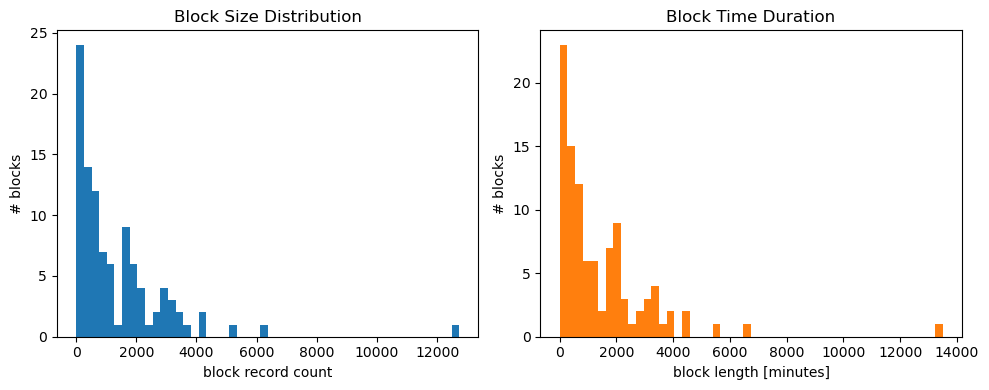

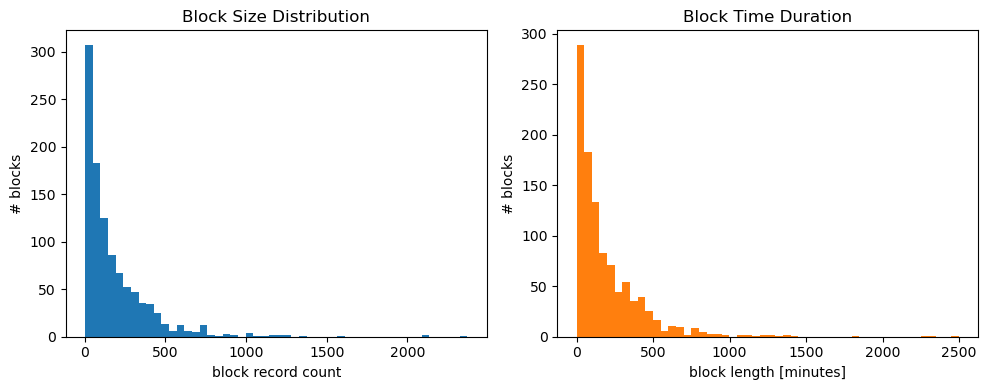

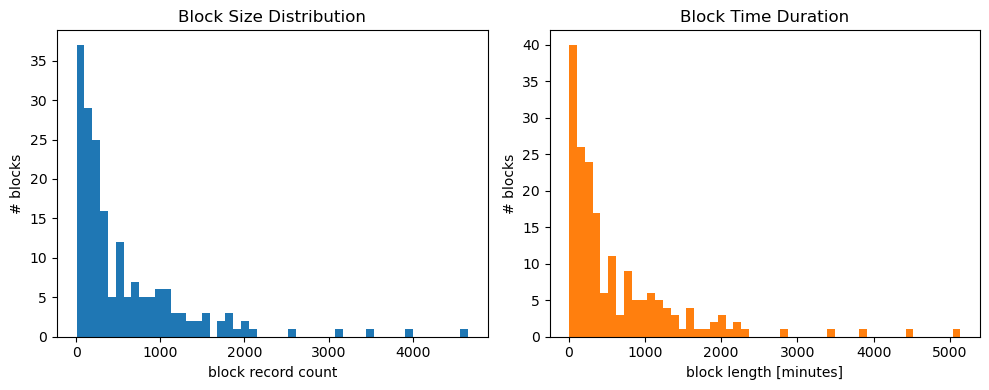

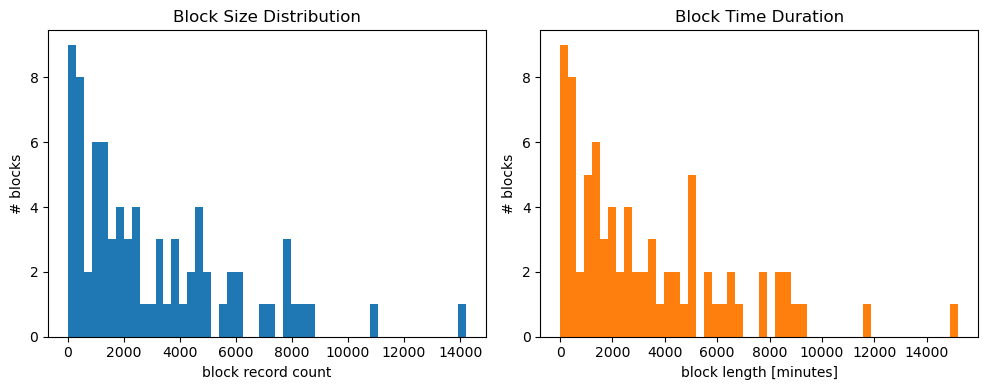

In [23]:
for hw in list_hw:

    print_separator(hw) #function to display a nice line separator with name
    dist_blocks = df_blocks.where(col("hwid")==hw).groupBy("BlockID").agg(count("*").alias("Block count")).orderBy("Block count")
    data = dist_blocks.toPandas()
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].hist(data['Block count'], bins=50)
    axes[0].set_xlabel("block record count")
    axes[0].set_ylabel("# blocks")
    axes[0].set_title("Block Size Distribution")

    dist_blocks_min = (
        df_blocks.where(col("hwid") == hw)
        .groupBy("BlockID")
        .agg(((spark_max("when") - spark_min("when"))/60).alias("minutes"))
        .orderBy("minutes")
    )
    data = dist_blocks_min.toPandas()

    axes[1].hist(data['minutes'], bins=50, color = "#ff7f0e")
    axes[1].set_xlabel("block length [minutes]")
    axes[1].set_ylabel("# blocks")
    axes[1].set_title("Block Time Duration")
    

    plt.tight_layout()
    plt.show()

# Anomaly detection (1)

## Distributed Analysis for Anomaly Detection

In [24]:
def detect_anomalies(df, time_separator, threshold, sensors):
    # Lag to get previous value within each partition (i.e. within each block)
    window         = Window.partitionBy("BlockID").orderBy("when")
    lagged_columns = [lag(col(s)).over(window) for s in sensors] 
    lag_names      = [f"lagged_{s}" for s in sensors]
    
    df_lagged = df.withColumns(dict(zip(lag_names, lagged_columns)))

    # Determina switch del sensore (didSwitch = 1 se il sensore passa da 0 a 1 o viceversa, didSwitch = 0 altrimenti)
    switch_w     = Window.partitionBy('BlockID').orderBy('when')
    didSwitch    = [when((col(f"lagged_{s}") != col(s)), 1).otherwise(0) for s in sensors] 
    switch_names = [f"didSwitch_{s}" for s in sensors]    

    df_didSwitch = df_lagged.withColumns(dict(zip(switch_names, didSwitch)))

    # Detect anomaly group: when two clusters are more distant than time_separator they are grouped as different anomalies
    # Tutte le anomalie di uno stesso gruppo hanno stesso id, cioè un numero crescente che si resetta ad ogni nuovo blocco
    df_anomalies = df_didSwitch
    for sensor in sensors:   
        # Il periodo anomalo inizia quando il sensore è 1 e finisce quando esso è 0
        df_start = (
            df_didSwitch \
            .withColumn(f'theres0Before_{sensor}', count_if(col(sensor) == 0).over(window.rangeBetween(1, time_separator)) > 0) \
            .withColumn(f'theres0After_{sensor}', count_if(col(sensor) == 0).over(window.rangeBetween(-time_separator, -1)) > 0) \
            .filter( 
                (col(f'didSwitch_{sensor}') == 1) & 
                (when(col(sensor) == 1, col(f'theres0Before_{sensor}')).otherwise(True)) &
                (when(col(sensor) == 0, col(f'theres0After_{sensor}')).otherwise(True))
            ) \
            .withColumn(f'startGroup_{sensor}', when((col('when')-lag(col('when'), 1, -1e9).over(window))>time_separator, 1).otherwise(0)) \
            .withColumn(f'anomalyID_{sensor}', spark_sum(col(f'startGroup_{sensor}')).over(window)) \
        )
        
        df_anomalies = df_anomalies.join(
            other = df_start.select('BlockID', 'when', f'startGroup_{sensor}', f'anomalyID_{sensor}'),
            on = ['BlockID', 'when'],
            how = 'left'
        )

    count_names = [f'count_{s}' for s in sensors]
    count_cols  = [count('*').over(Window.partitionBy('BlockID', f'anomalyID_{s}')) for s in sensors]

    flag_names  = [f'flag_{s}' for s in sensors]
    flag_cols   = [when((col(f'count_{s}') >= threshold) & (col(f'anomalyID_{s}') > 0), True).otherwise(False) for s in sensors]
    
    df_flag = df_anomalies \
        .withColumns(dict(zip(count_names, count_cols))) \
        .withColumns(dict(zip(flag_names, flag_cols))) \
        .orderBy('BlockID', 'when')

    # Quando ci sono delle righe comprese tra anomalie con stesso ID, queste righe sono a loro volta considerate anomalie
    next_w  = Window.partitionBy('BlockID').orderBy('when').rangeBetween(0, time_separator)
    prev_w  = Window.partitionBy('BlockID').orderBy('when').rangeBetween(-time_separator, 0)

    prev_names = [f'prevID_{s}' for s in sensors]
    prev_id = [when((bool_or(f'flag_{s}').over(prev_w)), spark_max(f'anomalyID_{s}').over(prev_w)).otherwise(None) for s in sensors]
    next_names = [f'nextID_{s}' for s in sensors]
    next_id = [when((bool_or(f'flag_{s}').over(next_w)), spark_min(f'anomalyID_{s}').over(next_w)).otherwise(None) for s in sensors]

    df_newID = (
        df_flag \
            .withColumns(dict(zip(prev_names, prev_id))) \
            .withColumns(dict(zip(next_names, next_id)))
    )

    new_flags = [when((col(f'nextID_{s}') == col(f'prevID_{s}')) & (col(f'nextID_{s}') > 0), True).otherwise(col(f'flag_{s}')) for s in sensors]
    
    df_flag = df_newID.withColumns(dict(zip(flag_names, new_flags)))
    
    condition = reduce(lambda a, b: a | b, [col(f'flag_{s}') for s in sensors])
    df_flag = df_flag.withColumn('flag_anomaly', when(condition, 1).otherwise(0))

    return df_flag \
        .select("BlockID", "when", *sensors, *flag_names, 'flag_anomaly') 

In [25]:
%%time

list_df_anomalies = {}
for hw in list_hw:
    df_anomalies = detect_anomalies(
        df = df_blocks.filter( col("hwid") == hw),
        time_separator = 60*40, # seconds
        threshold = 8,
        sensors = engines
    )

    list_df_anomalies[hw] = df_anomalies

CPU times: user 230 ms, sys: 96.1 ms, total: 326 ms
Wall time: 5.45 s


In [26]:
%%time

hw_to_inspect = 'SW-088'
list_df_anomalies[hw_to_inspect].filter('flag_S117').show(3, truncate=False)

+-------+----------+----+----+----+----+---------+---------+---------+---------+------------+
|BlockID|when      |S117|S118|S169|S170|flag_S117|flag_S118|flag_S169|flag_S170|flag_anomaly|
+-------+----------+----+----+----+----+---------+---------+---------+---------+------------+
|71     |1602481950|1   |0   |1   |1   |true     |false    |true     |false    |1           |
|71     |1602482010|1   |0   |0   |1   |true     |false    |true     |false    |1           |
|71     |1602482070|0   |0   |0   |1   |true     |false    |true     |false    |1           |
+-------+----------+----+----+----+----+---------+---------+---------+---------+------------+
only showing top 3 rows

CPU times: user 3.31 ms, sys: 4.67 ms, total: 7.98 ms
Wall time: 4.8 s


In [27]:
print("Know some BlockID where there are anomalies, so we can plot it and see.")

BlockWithAnom = list_df_anomalies[hw_to_inspect].filter('flag_S117').select('BlockID').distinct().orderBy('BlockID')
listBlockAnom = BlockWithAnom.collect()

Know some BlockID where there are anomalies, so we can plot it and see.


In [28]:
def inspect_anomalies(df, sensor, blockID):
    def extract_column(df, column, default):
        return df.filter(col('BlockID') == blockID) \
            .select(when(col(column).isNull(), default).otherwise(col(column))) \
            .rdd.flatMap(lambda x: x).collect()
    def extract_when(df):
        return df.filter(col('BlockID') == blockID) \
            .select('when') \
            .rdd.flatMap(lambda x: x).collect()

    values    = extract_column(df, sensor, 0)
    anomalies = extract_column(df, f'flag_{sensor}', False)
    whens     = extract_when(df)

    fig, axes = plt.subplots(1, 2, figsize=(14,5))

    t_min, t_max = min(whens), max(whens)
    full_t = list(range(t_min, t_max + 60, 60))
    full_t_rel = [(t - t_min) // 60 for t in full_t]
    whens_rel  = [(w - t_min) // 60 for w in whens]
    values_map    = dict(zip(whens_rel, values))
    anomalies_map = dict(zip(whens_rel, anomalies))
    aligned_values    = [values_map.get(t, 0) for t in full_t_rel]
    aligned_anomalies = [anomalies_map.get(t, 0) for t in full_t_rel]
    missing = [0.5 if t not in whens_rel else 0 for t in full_t_rel]
    combined_anomalies = [max(a, m) for a, m in zip(aligned_anomalies, missing)]

    axes[0].bar(full_t_rel, aligned_values, width=1, alpha=0.7, color="blue", label=sensor)
    axes[0].bar(full_t_rel, missing, width=1, alpha=0.8, color="red", label="time hole")
    axes[0].bar(full_t_rel, combined_anomalies, width=1, alpha=0.5, color="orange", label="anomal")
    axes[0].set_xlabel("Minutes (relative to block start)")
    axes[0].set_ylabel(sensor)
    axes[0].legend(loc='lower right')
    axes[0].set_title(f"Block N.{blockID} (raw)")

    t = range(len(anomalies))
    axes[1].bar(t, values, width=1, alpha=0.5, lw=1)
    axes[1].bar(t, anomalies, width=1, alpha=0.5, label="anomal")
    axes[1].set_xlabel("Consecutive available data")
    axes[1].set_ylabel(sensor)
    axes[1].legend(loc='lower right')
    axes[1].set_title(f"Block N.{blockID} (aligned)")

    plt.tight_layout()
    plt.show()

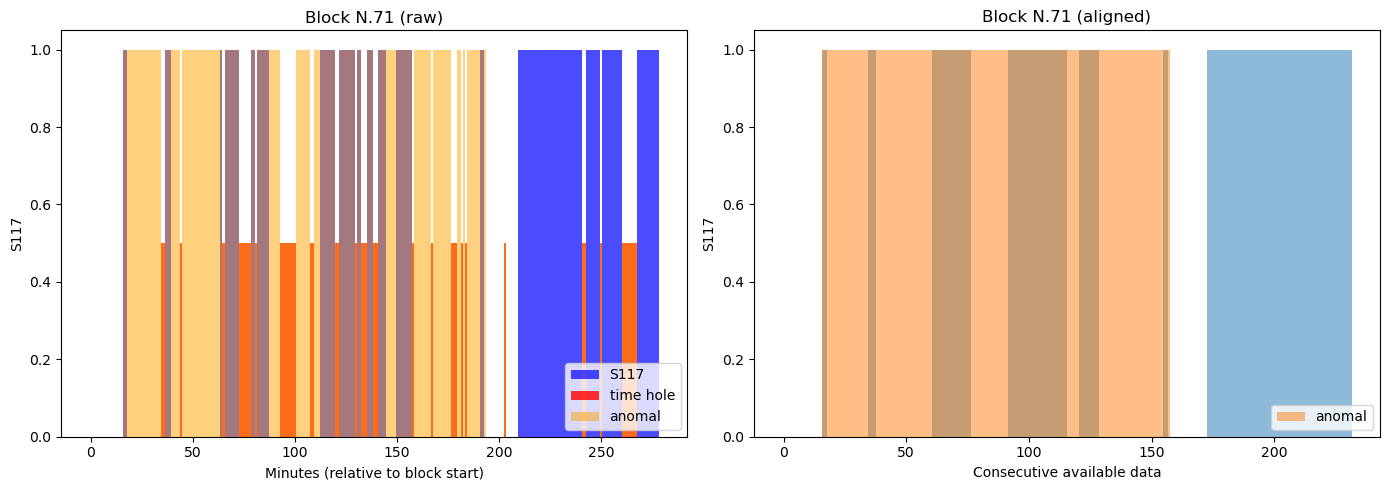

In [29]:
for row in listBlockAnom[:1]:
    inspect_anomalies(list_df_anomalies[hw_to_inspect], 'S117', row[0])

In [30]:
# Join on `when` and take just `flag_anomaly`

list_df_blocks_anom = {}

for hw in list_hw:
    df_anom = list_df_anomalies[hw].select('when', 'flag_anomaly')
    list_df_blocks_anom[hw] = df_blocks.filter( col("hwid") == hw ).join( df_anom, on='when', how='left' )

## Linear correlation setup (used for anomalies, S125-S181, A5-A9)

In [9]:
def correlations(df, sensors_list, target_col, batch_size=25): 
    all_correlations = []
    
    # Process sensors in batches to avoid broadcasting large tasks
    for i in range(0, len(sensors_list), batch_size):
        batch_sensors = sensors_list[i:i + batch_size]
        
        # Create correlation expressions for current batch
        corr_expressions = [corr(target_col, sensor).alias(f"corr_{sensor}") for sensor in batch_sensors]
        
        # Execute correlations for this batch
        batch_results = df.agg(*corr_expressions).collect()[0]
        
        # Extract correlation values (handle nulls as 0.0)
        batch_correlations = [batch_results[f"corr_{sensor}"] or 0.0 
                            for sensor in batch_sensors]
        all_correlations.extend(batch_correlations)
    
    # Create DataFrame with results
    results_df = pd.DataFrame({
        "Sensors": sensors_list, 
        "Correlations": all_correlations
    })
    
    # Sort by absolute correlation (highest first)
    sorted_results = results_df.reindex(
        results_df["Correlations"].abs().sort_values(ascending=False).index
    ).reset_index(drop=True)
    
    return sorted_results

In [10]:
def plot_correlations(df_spark, target_col, feature_cols, corr_df, hw):
    pd_df = df_spark.select(target_col, *feature_cols).toPandas()
    
    for feature in feature_cols:
        corr_val = corr_df[corr_df["Sensors"] == feature]["Correlations"].values
        corr_str = f"{corr_val[0]:.3f}" if len(corr_val) > 0 else "N/A"
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        ax1.scatter(pd_df[feature], pd_df[target_col], color="steelblue", alpha=0.005)
        ax1.set_ylabel(target_col)
        
        for target_val, color in zip([0, 1], ["steelblue", "tomato"]):
            subset = pd_df[pd_df[target_col] == target_val]
            ax2.hist(subset[feature], bins=30, alpha=0.5, color=color, 
                    label=f"{target_col}={target_val}", density=True)
        
        ax2.set_ylabel("Density")
        ax2.legend()
        
        fig.suptitle(f"{hw} - {feature} - Correlation: {corr_str}")
        plt.tight_layout()
        plt.show()

## Correlation Analysis for Anomalies

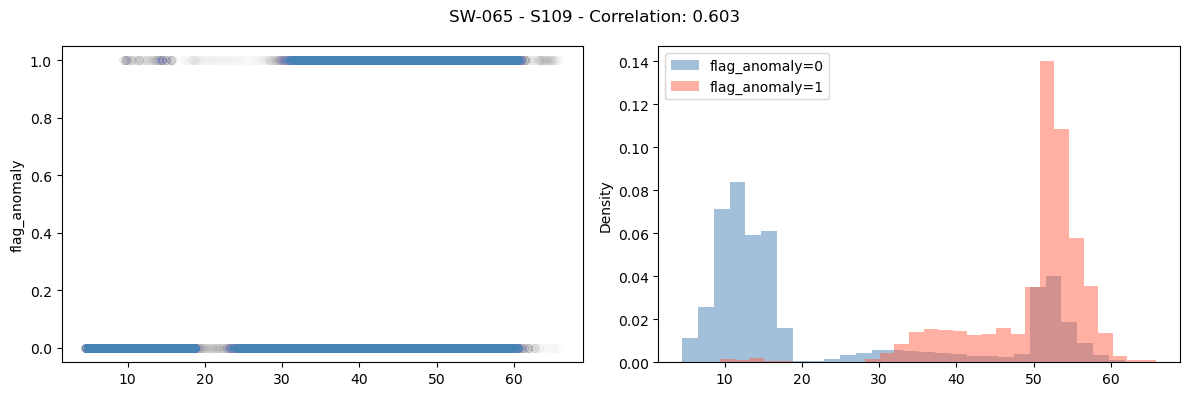

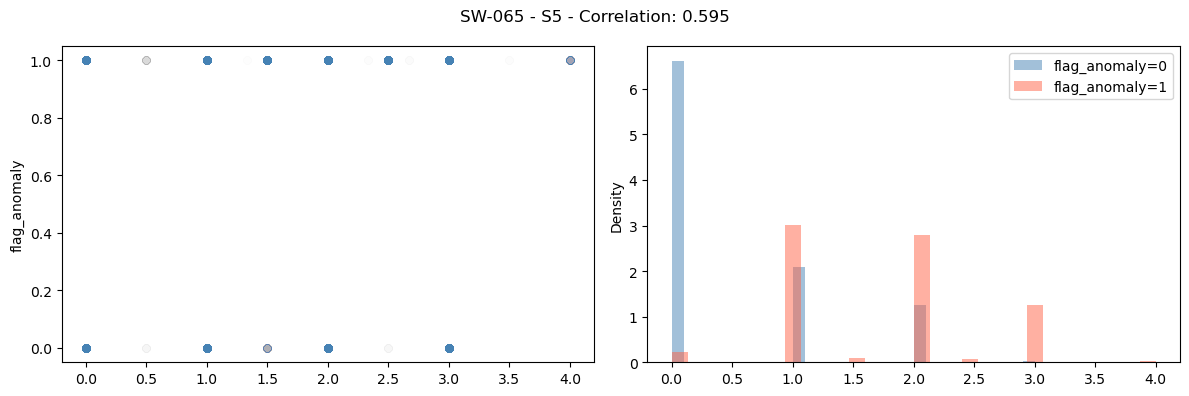

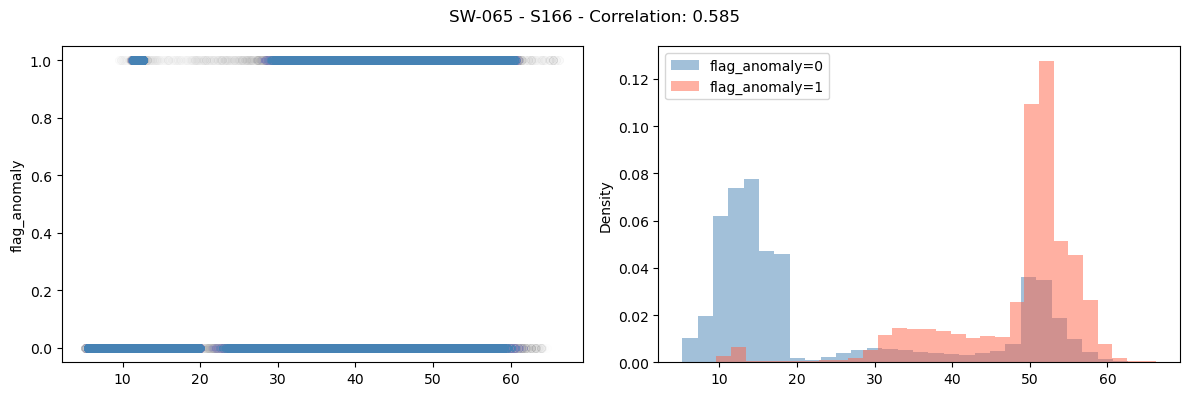

ERROR:root:KeyboardInterrupt while sending command.                             
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ~~~~~~~~~~~~~~~~~~~~^^
  File "/opt/miniconda3/lib/python3.13/socket.py", line 719, in readinto
    return self._sock.recv_into(b)
           ~~~~~~~~~~~~~~~~~~~~^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [33]:
%%time

for hw in list_hw:

    print_separator(hw)
    anomaly_corr = correlations(list_df_blocks_anom[hw], useful_sensors, 'flag_anomaly')
    top_anom_corr = anomaly_corr.head(3)['Sensors'].tolist()
    plot_correlations(list_df_blocks_anom[hw], 'flag_anomaly', top_anom_corr, anomaly_corr, hw)

## Alternative approach: Random Forest 

In [41]:
#Model the training set balancing the flag anomalies ratio
hw = 'SW-088'

df_final_flag0 = df_all_hw.filter(col('flag_anomaly')==0)
df_final_flag1 = df_blocks.filter(col('flag_anomaly')==1)

to_drop_df = df_final_flag0.sample(withReplacement = False, fraction = 0.85, seed = 2503)

df_final_flag0_reduced = df_final_flag0.subtract(to_drop_df)

df_final_balanced = df_final_flag1.union(df_final_flag0_reduced)


#Check for the ratio between the flag anomalies 1 and 0
flag_ratio = df_final_balanced.filter(col('flag_anomaly')==1).count()/df_final_balanced.filter(col('flag_anomaly')==0).count()

print("Ratio [1/0]:",flag_ratio)

25/08/24 16:16:17 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `flag_anomaly` cannot be resolved. Did you mean one of the following? [`ComError`, `when`, `A5`, `A9`, `BlockID`].;
'Filter ('flag_anomaly = 0)
+- Project [hwid#0, when#1L, window_start#2, window_end#3, A5#284, A9#428, ComError#6, P1#7, P10#8, P15#9, P16#10, P17#11, P18#12, P2#13, P5#14, P6#15, P7#16, P8#17, P9#18, S1#19, S10#20, S100#21, S101#22, S102#23, ... 90 more fields]
   +- Project [hwid#0, when#1L, window_start#2, window_end#3, A5#284, cast(A9#5 as int) AS A9#428, ComError#6, P1#7, P10#8, P15#9, P16#10, P17#11, P18#12, P2#13, P5#14, P6#15, P7#16, P8#17, P9#18, S1#19, S10#20, S100#21, S101#22, S102#23, ... 118 more fields]
      +- Project [hwid#0, when#1L, window_start#2, window_end#3, cast(A5#4 as int) AS A5#284, A9#5, ComError#6, P1#7, P10#8, P15#9, P16#10, P17#11, P18#12, P2#13, P5#14, P6#15, P7#16, P8#17, P9#18, S1#19, S10#20, S100#21, S101#22, S102#23, ... 118 more fields]
         +- Relation [hwid#0,when#1L,window_start#2,window_end#3,A5#4,A9#5,ComError#6,P1#7,P10#8,P15#9,P16#10,P17#11,P18#12,P2#13,P5#14,P6#15,P7#16,P8#17,P9#18,S1#19,S10#20,S100#21,S101#22,S102#23,... 118 more fields] parquet


In [37]:
def run_random_forest(df, feature_cols, label_col="label", n_trees=100, max_depth=5, test_fraction=0.2, seed = 2503):
    
    train_df, test_df = df.randomSplit([1 - test_fraction, test_fraction], seed=seed)
    print(f"Training on {train_df.count()} rows, testing on {test_df.count()} rows")
    
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

    rf = RandomForestClassifier(labelCol=label_col, featuresCol="features", numTrees=n_trees, maxDepth=max_depth,  seed=seed)

    pipeline = Pipeline(stages=[assembler, rf]) #La pipeline serve per dire a Spark di eseguire due operazioni consecutive, poi Spark si arrangia a gestirle in questo modo

    model = pipeline.fit(train_df) 

    train_predictions = model.transform(train_df)
    test_predictions = model.transform(test_df)

    evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
    test_accuracy = evaluator.evaluate(test_predictions)

    print(f"RandomForest trained with {n_trees} trees, maxDepth={max_depth}")
    print(f"Test Accuracy = {test_accuracy:.4f}")

    rf_model = model.stages[-1] 
    importances = rf_model.featureImportances.toArray()
    feature_importance = sorted(zip(feature_cols, importances), key=lambda x: -x[1])

    print("\nFeature Importances:")
    for col, imp in feature_importance:
        print(f"{col}: {imp:.4f}")

    return model, train_predictions, test_predictions, test_accuracy

In [38]:

useful_sensors = ['P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S107', 'S109', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S151', 'S154', 'S157', 'S158', 'S159', 'S164', 'S166', 'S169', 'S170', 'S171', 'S172', 'S173', 'S174', 'S178', 'S179', 'S180', 'S181', 'S183', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S35', 'S37', 'S39', 'S40', 'S41', 'S46', 'S47', 'S5', 'S53', 'S55', 'S6', 'S64', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA2', 'SA3', 'SA5', 'SA6', 'SA7', 'SA9']

In [39]:
%%time

vector_to_drop = ['A5', 'A9', 'ComError', 'overheating']

sensors_forest = [s for s in useful_sensors if s not in vector_to_drop]

model, train_preds, test_preds, test_accuracy = run_random_forest(df_final_balanced, feature_cols=sensors_forest, label_col="flag_anomaly", n_trees = 120, max_depth = 10, test_fraction=0.33333)

test_preds.select('flag_anomaly', 'prediction', 'probability').show(10, truncate = 0)

Training on 32293 rows, testing on 16225 rows


IllegalArgumentException: P1 does not exist. Available: BlockID, when, S117, S118, S169, S170, flag_S117, flag_S118, flag_S169, flag_S170, flag_anomaly

In [40]:
#Prediction with the obtained model
n = 20
data_row = df_final_balanced.orderBy(rand()).limit(n)

predicted_data = model.transform(data_row)
predicted_data.select("S109", "S166", "S102", "flag_anomaly", "prediction").show()

NameError: name 'model' is not defined

# Anomaly Detection (2)

## Correlation between device load and external temperature (S125-S181 vs S41) (Attualmente not working)

In [ ]:
%%time

load_sensors = ['S125', 'S181']
temperature_sensor = 'S41'

for hw in list_hw:
    print_separator(hw)
    temper_corr = correlations(list_df_blocks_anom[hw], load_sensors, temperature_sensor)

    plot_correlations(list_df_blocks_anom[hw], temperature_sensor, load_sensors, temper_corr, hw)

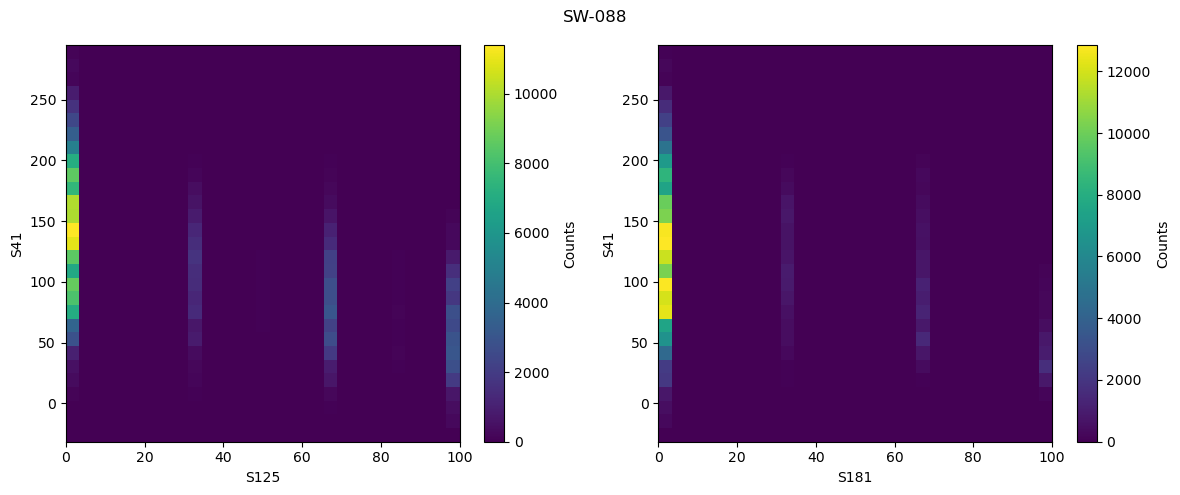

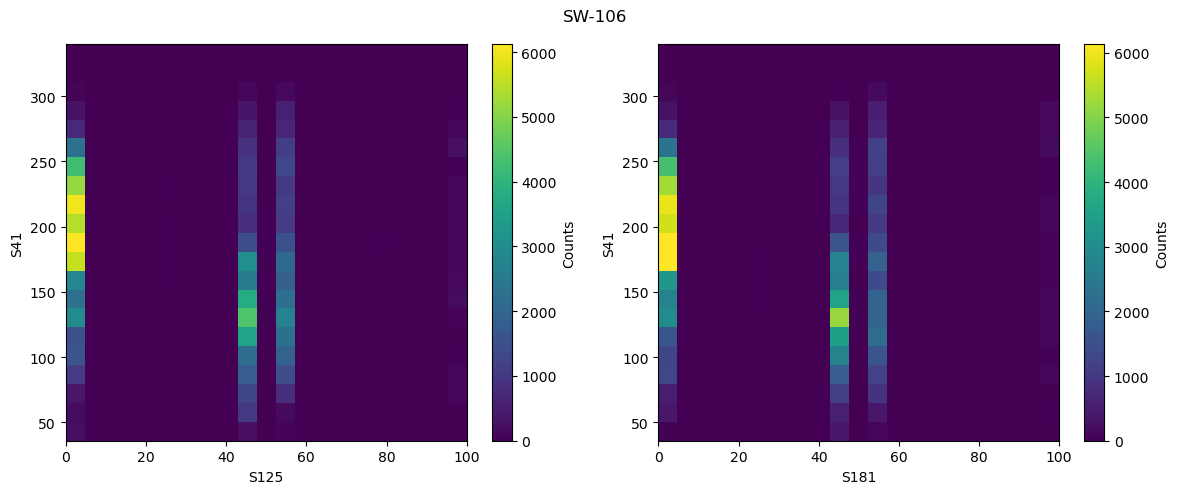

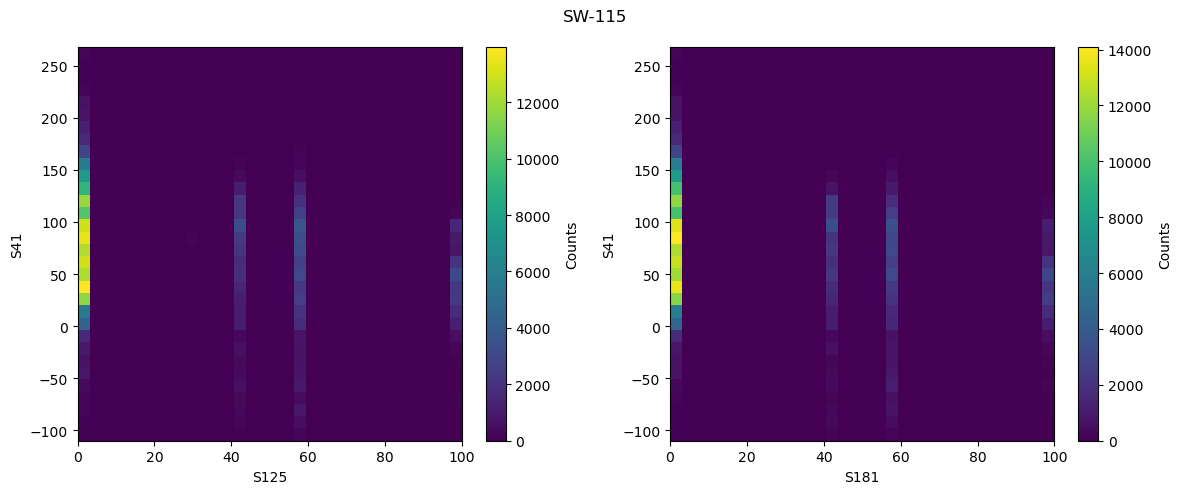

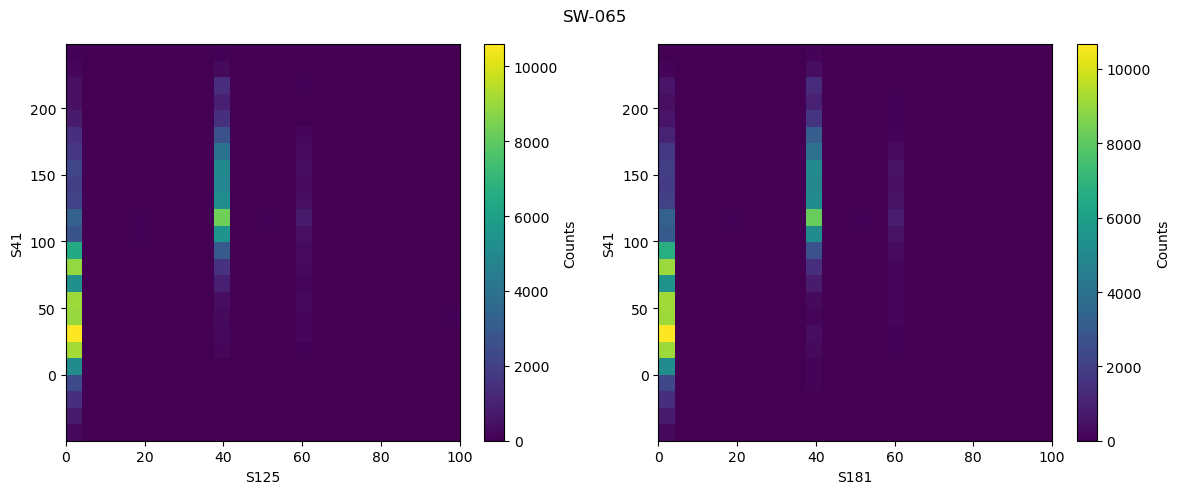

In [17]:
load_sensors = ['S125', 'S181']
temperature_sensor = 'S41'

# Inspect joint distribution of S41 and device load

for hw in list_hw:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    # fig.subplots_adjust(wspace=0.4)
    fig.suptitle(f"{hw}")
    
    for i in range(len(load_sensors)):
        load_sensor = load_sensors[i]
        filtered_df = list_df_blocks_anom[hw].dropna(subset=(temperature_sensor, load_sensor))
        
        temperature = filtered_df.select(temperature_sensor).rdd.flatMap(lambda x: x).collect()
        load        = filtered_df.select(load_sensor).rdd.flatMap(lambda x: x).collect()
        bins = int(np.sqrt(len(temperature))/15)
        
        counts, xedges, yedges, im = ax[i].hist2d(load, temperature, bins=bins)
        cbar = fig.colorbar(im, ax=ax[i])   
        cbar.set_label('Counts')  
        ax[i].set_ylabel(temperature_sensor)
        ax[i].set_xlabel(load_sensor)
        
    plt.tight_layout()    
    plt.show()

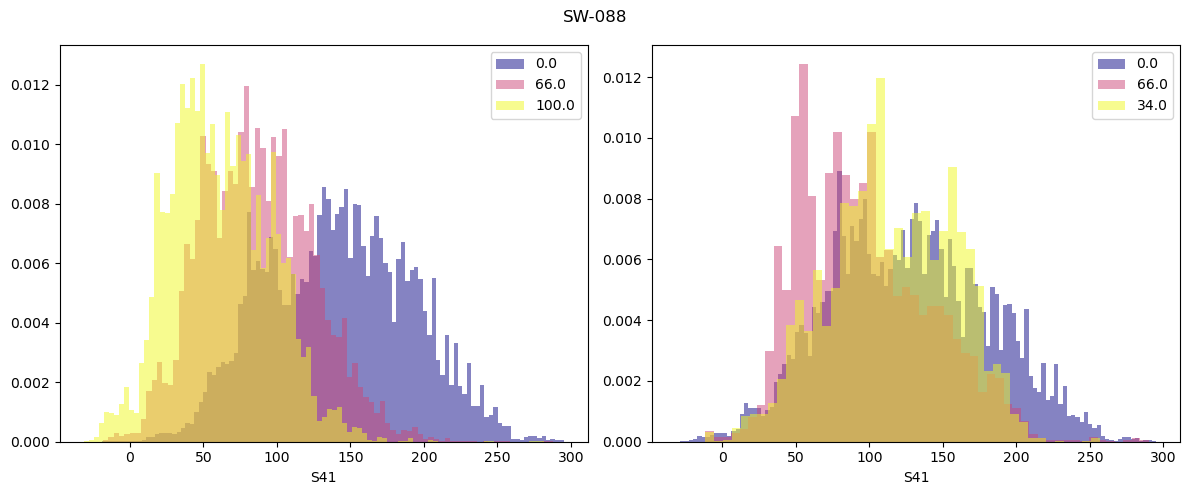

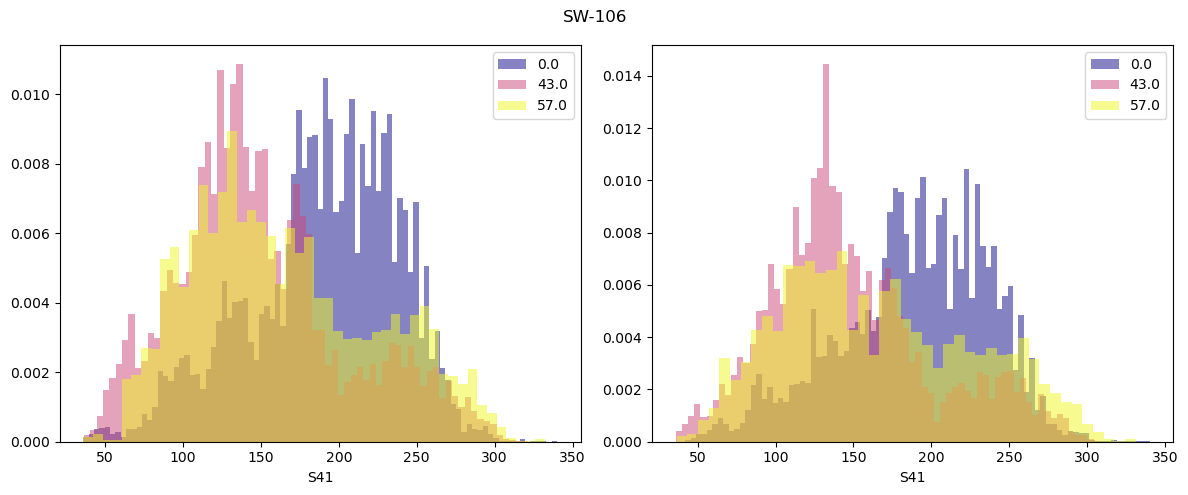

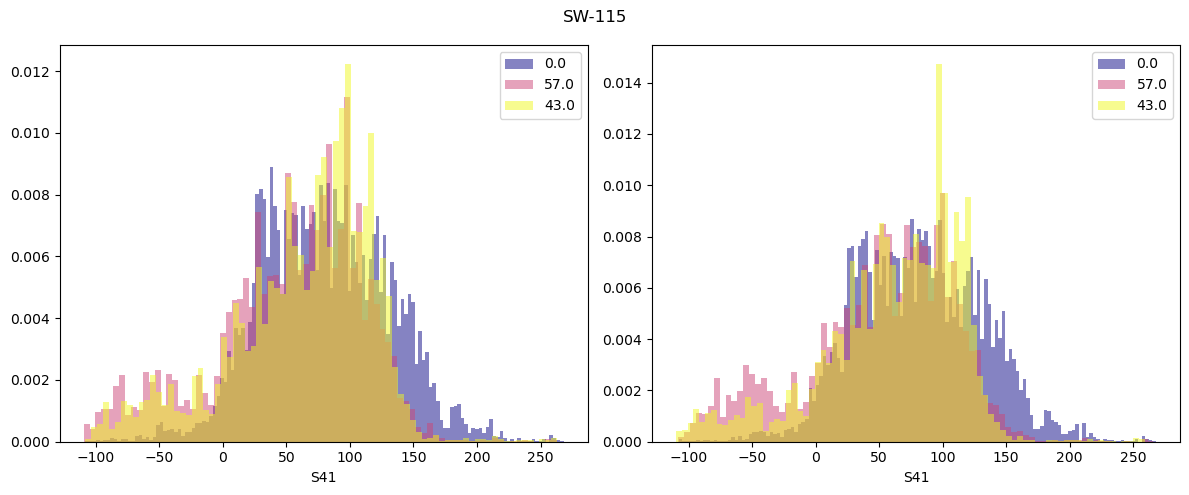

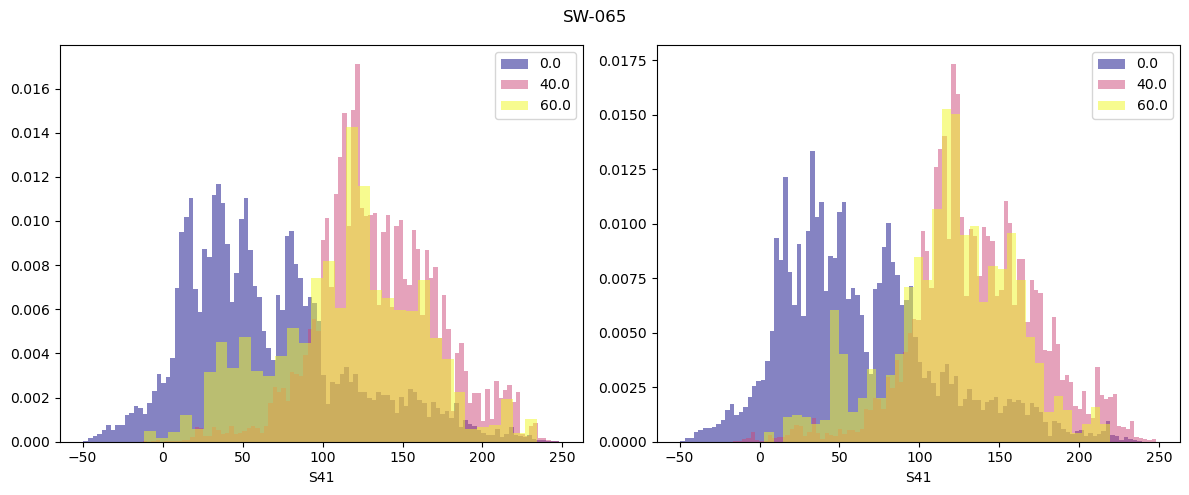

CPU times: user 3.91 s, sys: 178 ms, total: 4.08 s
Wall time: 49.6 s


In [18]:
%%time

# Inspect overlap of temperature distributions for different work load percentages

n_distributions = 3 # Show the first n most numerous distributions

for hw in list_hw:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"{hw}")
    
    for i in range(len(load_sensors)):
        load_sensor = load_sensors[i]
        noNull_df = list_df_blocks_anom[hw].dropna(subset=(temperature_sensor, load_sensor))

        top_load_percentages = noNull_df \
            .select(load_sensor) \
            .groupBy(load_sensor) \
            .count() \
            .sort('count', ascending=False) \
            .limit(n_distributions) \
            .select(load_sensor) \
            .rdd.flatMap(lambda x: x) \
            .collect()
        # In alternativa, se lento fare pivot intorno a load_sensor dopo il filtro
        # print(load_sensor, ': ', top_load_percentages)
        
        cmap = plt.get_cmap('plasma') # viridis, plasma
        colors = [cmap(i) for i in np.linspace(0, 1, n_distributions)]

        for load_percentage, color in zip(top_load_percentages, colors): 
            temperature = noNull_df \
                .filter(f'{load_sensor} = {load_percentage}') \
                .select(temperature_sensor) \
                .rdd.flatMap(lambda x: x) \
                .collect()
            # bins = int(np.sqrt(len(temperature))/2)
            
            ax[i].hist(temperature, bins='auto', color=color, alpha=0.5, label=f'{load_percentage}', density=True)  
            ax[i].set_xlabel(temperature_sensor)
            ax[i].legend()
            
    plt.tight_layout()    
    plt.show()

# Predictive maintenance

## Conversion of Alarms (A5, A9)

In [ ]:
def extract_alarms(df, columns=["A5", "A9"], bits=[6, 7, 8]):
    for col_name in columns:
        for bit in bits:
            convert_bit = bit - 1  # bit 1 is LSB
            df = df.withColumn( f"{bit}-{col_name}", ((col(col_name).bitwiseAND(1 << convert_bit)) > 0).cast("int") )

    df = df.withColumn(
        "overheating",
        when(
            (col("6-A5") == 1) | (col("7-A5") == 1) | (col("8-A5") == 1) | (col("6-A9") == 1) | (col("7-A9") == 1) | (col("8-A9") == 1) ,
            1
            ).otherwise(0).cast("int")
            ).where( (col("A5").isNotNull()) | (col("A9").isNotNull()) )
    return df

In [ ]:
%%time

list_df_final = {}

for hw in list_hw:
    df_final = list_df_blocks_anom[hw].join( list_df_alarms[hw].select('when', 'overheating') , on='when', how='left' )
    list_df_final[hw] = df_final

In [ ]:
# Extract bits from alarms

list_df_alarms = {}
for hw in list_hw:
    df_alarms = extract_alarms(df_blocks.filter( col("hwid") == hw).select("when","A5","A9"),
                            columns=["A5", "A9"],
                            bits=[6, 7, 8] )

    list_df_alarms[hw] = df_alarms
    print( f"For hardware {hw} were recorded {df_alarms.agg(spark_sum(col('overheating'))).collect()[0][0]} overheating signals." )

list_df_alarms['SW-088'].where( col("overheating") == 1 ).show(10)

## Correlation analysis for alarms

In [19]:
# #DOCKER PER MARCO
# alarm_corr = correlations(df_final_088, useful_sensors, 'overheating')
# top_alarm_corr = alarm_corr.head(3)['Sensors'].tolist()
# plot_correlations(df_final_088, 'overheating', top_alarm_corr, alarm_corr, 'SW-088')

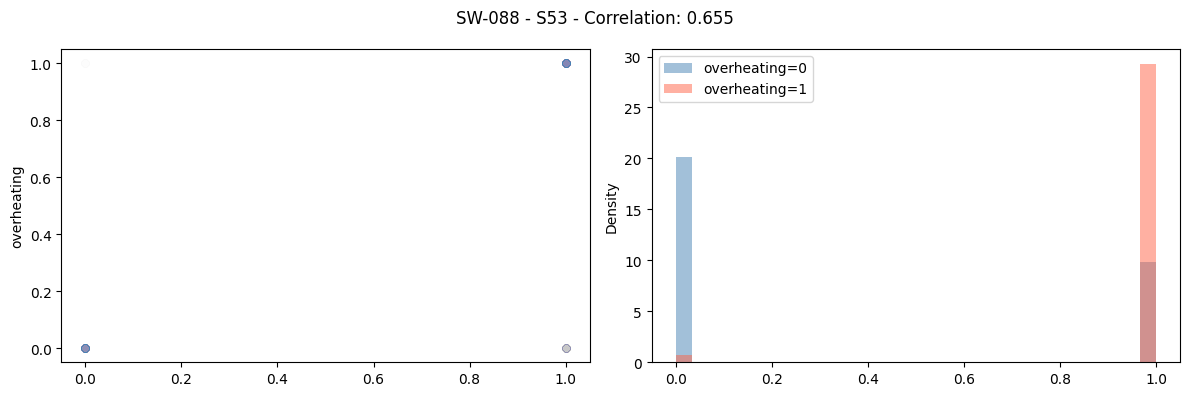

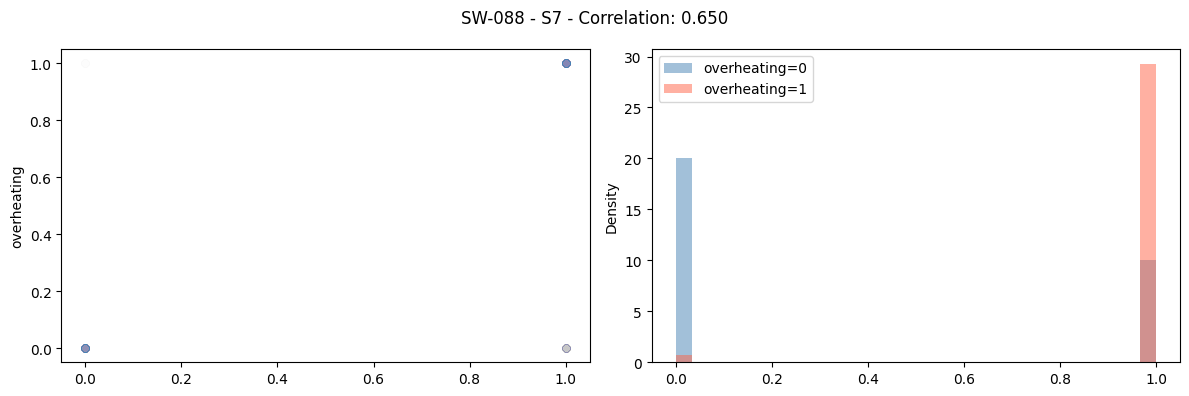

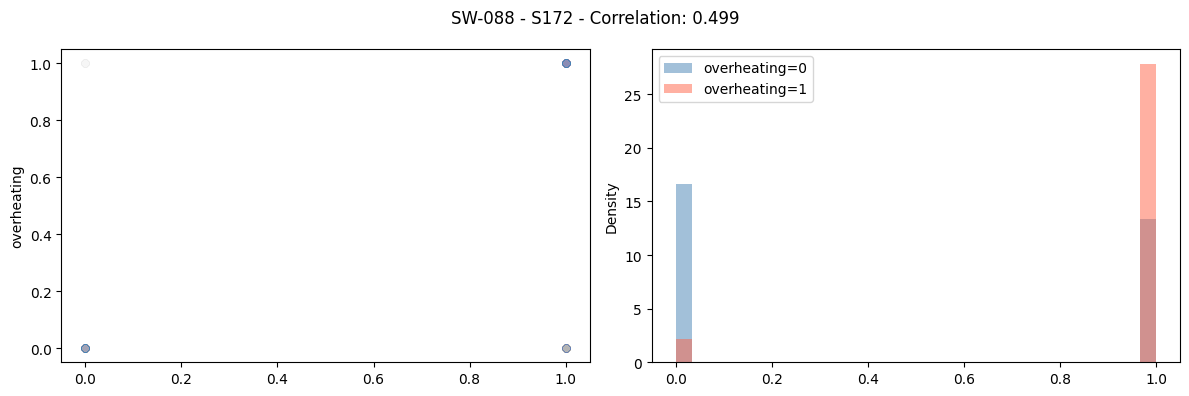

In [77]:
#DOCKER PER MARCO
alarm_corr = correlations(df_final_088, useful_sensors, 'overheating')
top_alarm_corr = alarm_corr.head(3)['Sensors'].tolist()
plot_correlations(df_final_088, 'overheating', top_alarm_corr, alarm_corr, 'SW-088')

In [13]:
hw_to_inspect = 'SW-088'
alarm_corr = correlations(list_df_final[hw_to_inspect], useful_sensors, 'overheating')
alarm_corr.head(10)

25/08/25 09:13:20 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

,Sensors,Correlations
0,S53,0.654998
1,S7,0.649957
2,S172,0.498684
3,S173,-0.489226
4,S39,0.405736
5,S40,0.404673
6,S3,0.401989
7,P16,0.384099
8,P2,0.378371
9,S35,-0.357743


In [14]:
%%time

for hw in list_hw:
    print_separator(hw)
    alarm_corr = correlations(list_df_final[hw], useful_sensors, 'overheating')

    top_alarm_corr = alarm_corr.head(3)['Sensors'].tolist()
    
    plot_correlations(list_df_final[hw], 'overheating', top_alarm_corr, alarm_corr, hw)

NameError: name 'list_hw' is not defined

# Predictive modeling 

## Add predictive flag

In [43]:
df_final_088 = list_df_final['SW-088'] # the only one in which there is overheating

NameError: name 'list_df_final' is not defined

25/08/24 16:19:57 ERROR TaskSchedulerImpl: Lost executor 0 on 10.67.22.142: Command exited with code 137
25/08/24 16:19:57 WARN TaskSetManager: Lost task 0.0 in stage 1114.0 (TID 1512) (10.67.22.142 executor 0): ExecutorLostFailure (executor 0 exited caused by one of the running tasks) Reason: Command exited with code 137
25/08/24 16:19:57 WARN TaskSetManager: Lost task 0.1 in stage 1114.0 (TID 1516) (10.67.22.228 executor 1): FetchFailed(BlockManagerId(0, 10.67.22.142, 34355, None), shuffleId=242, mapIndex=25, mapId=1480, reduceId=0, message=
org.apache.spark.shuffle.FetchFailedException
	at org.apache.spark.errors.SparkCoreErrors$.fetchFailedError(SparkCoreErrors.scala:437)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:1239)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:971)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.s

In [45]:
def add_predictive(df, target, window_before_heating=30, join=True ,debug=False): #window_before_heating in minutes

    w = Window.partitionBy("BlockID").orderBy("when")

    df_pred = df.select("BlockID","when","window_start",target)
    df_pred = df.withColumn(f"prev_{target}", lag(target).over(w))
    df_pred = df_pred.withColumn(
        f"is_start_{target}",
        when(
            (col(target) == 1) &
            ((col(f"prev_{target}") != 1) | col(f"prev_{target}").isNull()),
            1
        ).otherwise(0)
    )

    df_pred = df_pred.withColumn(f"start_time_{target}", when(col(f"is_start_{target}") == 1, col("when")))

    w_future = w.rowsBetween(Window.currentRow, Window.unboundedFollowing)
    df_pred = df_pred.withColumn(
        f"next_start_{target}",
        first(f"start_time_{target}", ignorenulls=True).over(w_future)
    )

    window_seconds = window_before_heating * 60
    df_pred = df_pred.withColumn(
    f"predictive_{target}",
        when(
            (col(f"next_start_{target}").isNotNull()) &
            (((col(target).isNull()) | (col(target) == 0))) &
            ((col(f"next_start_{target}") - col("when")) > 0) &
            ((col(f"next_start_{target}") - col("when")) <= window_seconds), 1 ).otherwise(0))

    if not debug:
        df_pred = df_pred.select("BlockID","when",target,f"predictive_{target}")


    if join:
        return df.join( df_pred.select('when', f'predictive_{target}') , on='when', how='left' )
    else:
        return df_pred

In [47]:
target = "overheating"
df_final_088 = add_predictive(df_final_088, target, window_before_heating=30, debug=False, join=True )
target = "flag_anomaly"
df_final_088 = add_predictive(df_final_088, target, window_before_heating=30, debug=False, join=True )
#df_final_088.filter(col("predictive_overheating") == 1).select('when', target, f'predictive_{target}').count()

1826

## Raffaele inserisci qui

In [26]:
data = {
    "Sensors": ["S53", "S7", "S172", "S173", "S39", "S40", "S3", "P16", "P2", "S33"],
    "Correlations": [0.654998, 0.649957, 0.498684, -0.489226, 0.405736, 0.404673, 0.401989, 0.384099, 0.378371, -0.357743]
}

alarm_corr = pd.DataFrame(data)

n_sensors = 4
prev_time = 600*60 # seconds
post_time = 600*60
window = Window.partitionBy('BlockID').orderBy('when')
top_corr_sensors = alarm_corr['Sensors'][0:n_sensors]
top_corrs        = alarm_corr['Correlations'][0:n_sensors]

In [30]:
indexed_df = (
    df_final_088 \
        .select('when', "window_start",*top_corr_sensors, 'overheating', 'BlockID') \
        .withColumn('overheating_count', count_if(col('overheating') == 1).over(window.rangeBetween(-post_time, prev_time)))
)

indexed_df.show(50)

+----------+-------------------+---+---+----+----+-----------+-------+-----------------+
|      when|       window_start|S53| S7|S172|S173|overheating|BlockID|overheating_count|
+----------+-------------------+---+---+----+----+-----------+-------+-----------------+
|1601566290|2020-10-01 15:31:00|  1|  1|   1|   0|       NULL|      3|                0|
|1601566350|2020-10-01 15:32:00|  1|  1|   1|   0|       NULL|      3|                0|
|1601566410|2020-10-01 15:33:00|  1|  1|   1|   0|       NULL|      3|                0|
|1601566470|2020-10-01 15:34:00|  1|  1|   1|   0|       NULL|      3|                0|
|1601566530|2020-10-01 15:35:00|  1|  1|   1|   0|       NULL|      3|                0|
|1601566590|2020-10-01 15:36:00|  1|  1|   1|   0|       NULL|      3|                0|
|1601566650|2020-10-01 15:37:00|  1|  1|   1|   0|       NULL|      3|                0|
|1601566710|2020-10-01 15:38:00|  1|  1|   1|   0|       NULL|      3|                0|
|1601566770|2020-10-0

     relative_time  S53  occurrance_rate
879          -3000    0         0.020000
880          -3000    1         0.980000
881          -2940    0         0.020408
882          -2940    1         0.979592
883          -2880    0         0.021277
884          -2880    1         0.978723
885          -2820    0         0.020833
886          -2820    1         0.979167
887          -2760    0         0.020408
888          -2760    1         0.979592
889          -2700    0         0.020000
890          -2700    1         0.980000
891          -2640    0         0.020000
892          -2640    1         0.980000
893          -2580    0         0.018868
894          -2580    1         0.981132
895          -2520    0         0.020000
896          -2520    1         0.980000
897          -2460    0         0.036364
898          -2460    1         0.963636
899          -2400    0         0.038462
900          -2400    1         0.961538
901          -2340    0         0.019608
902          -23

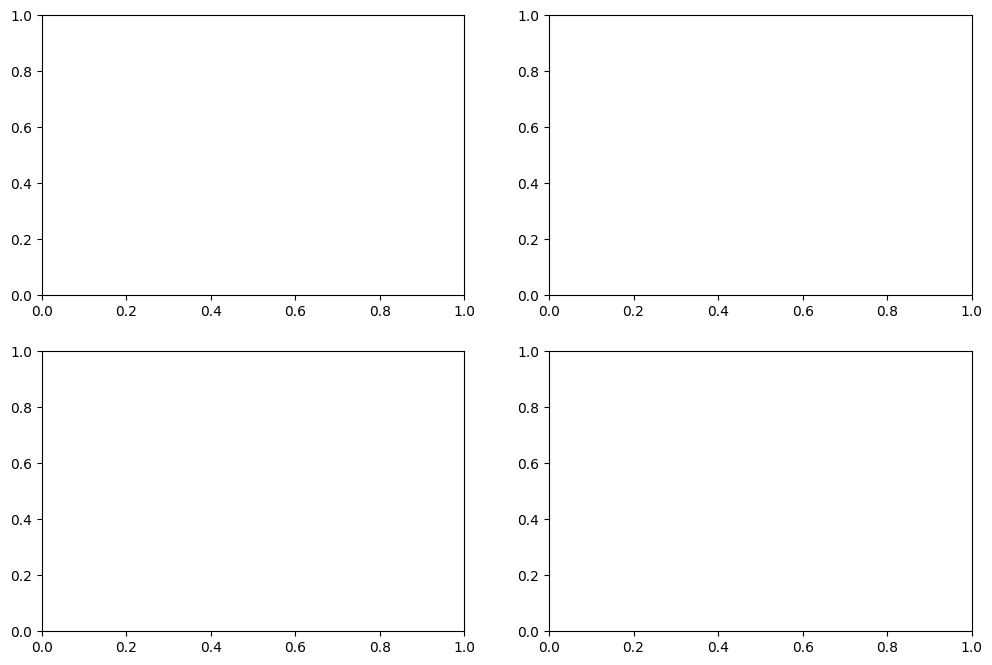

In [90]:
%%time

n_sensors = 4
prev_time = 600*60 # seconds
post_time = 600*60

window = Window.partitionBy('BlockID').orderBy('when')

top_corr_sensors = alarm_corr['Sensors'][0:n_sensors]
top_corrs        = alarm_corr['Correlations'][0:n_sensors]

# We center the rows order in such a way that 0 falls on the first occurrence of 1
# 1) Assign an index to each row
indexed_df = (
    df_final_088 \
        .select('when', *top_corr_sensors, 'overheating', 'BlockID') \
        .withColumn('overheating_count', count_if(col('overheating') == 1).over(window.rangeBetween(-post_time, prev_time))) \
        .withColumn('closeToOverheating', col('overheating_count') > 0) \
        .filter('closeToOverheating') \
        .withColumn('naive_order', row_number().over(window) - 1)
)

# 2) Find the timestamp of the first 1
timeOfOnes = (
    indexed_df \
        .filter('overheating = 1') \
        .groupBy('BlockID') \
        .agg(spark_min('when').alias('timestampOf1')) \
)

# 3) Subtract the position to every index
ordered_df = (
    indexed_df \
        .join(timeOfOnes, on='BlockID', how='left') \
        .withColumn('relative_time', col('when') - col('timestampOf1')) \
        .select('when', *top_corr_sensors, 'overheating', 'BlockID', 'relative_time')
)
# distinct_blocks = ordered_df.select('BlockID').distinct().rdd.flatMap(lambda x: x).collect()
# ordered_df.show(100)

totalOccurrences_df = ordered_df \
    .groupBy('relative_time') \
    .agg(count('*').alias('total_occurrences')) \
    .filter(f'relative_time < {post_time}')
# totalOccurrences_df.show(130)

# Now we perform the analysis: we group by relative_time and value (0, 1) for each sensor, then we compute the percentage over the total

fig, axes = plt.subplots(ceil(n_sensors/2), 2, figsize=(12, 2*n_sensors))

for i in range(n_sensors):
    sensor = top_corr_sensors[i]
    analysis_df = (
        ordered_df \
            .groupBy('relative_time', sensor) \
            .agg(count('*').alias('occurrences')) \
            .join(totalOccurrences_df, on='relative_time', how='left') \
            .withColumn('occurrance_rate', col('occurrences')/col('total_occurrences')) \
            .orderBy('relative_time', sensor) \
            .drop('occurrences', 'total_occurrences') \
            .toPandas()
    )

    #selected = (analysis_df[sensor] == 1)
    mask2 = (analysis_df["relative_time"] >= -50*60) & (analysis_df["relative_time"] <= 0)
    
    #mask = selected & mask2
    rate = analysis_df[mask2]

    pd.set_option("display.max_rows", None) 
    print(rate)
    # rounded_rate = [round(r, 2) for r in rate]
#     time = analysis_df[selected]['relative_time'] / 60
#     colors = ['red' if t == 0 else 'green' for t in time]
#     axes[i//2, i%2].plot(time, rate, color='green', alpha=0.5)
#     axes[i//2, i%2].scatter(time, rate, color=colors, alpha=0.8)
#     axes[i//2, i%2].set_xlabel('relative time [min]')
#     axes[i//2, i%2].set_title(f'freq. of {sensor}=1 during overheating')# - corr. {round(top_corrs[i], 2)}')

# plt.tight_layout()
# plt.show()

   
#print(distinct_blocks)
#plot_df.show(300, truncate=False)

## Marco sviluppa sulla base di raffaele (NUOVI BLOCCHI DATI DA INTERVALLI TRA OVERHEATING)

In [37]:
df = df_final_088
df = df.withColumn("overheating", coalesce(col("overheating"), lit(0)))
w = Window.orderBy("when")

df = df.withColumn("new_block_flag", when(lag("overheating",1).over(w) == 1, lit(1)).otherwise(lit(0)))
df = df.withColumn("oldBlockHeat", spark_sum("new_block_flag").over(w) + lit(1)) 
df.select("window_start","overheating","oldBlockHeat","new_block_flag").show(20)

25/08/25 10:05:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 10:05:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 10:05:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 10:05:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 10:05:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 10:05:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 1

+-------------------+-----------+------------+--------------+
|       window_start|overheating|oldBlockHeat|new_block_flag|
+-------------------+-----------+------------+--------------+
|2020-10-01 00:01:00|          0|           1|             0|
|2020-10-01 00:02:00|          0|           1|             0|
|2020-10-01 00:03:00|          0|           1|             0|
|2020-10-01 00:04:00|          0|           1|             0|
|2020-10-01 00:06:00|          1|           1|             0|
|2020-10-01 00:07:00|          1|           2|             1|
|2020-10-01 00:08:00|          0|           3|             1|
|2020-10-01 00:09:00|          0|           3|             0|
|2020-10-01 00:10:00|          0|           3|             0|
|2020-10-01 00:11:00|          0|           3|             0|
|2020-10-01 00:12:00|          0|           3|             0|
|2020-10-01 00:13:00|          0|           3|             0|
|2020-10-01 00:14:00|          0|           3|             0|
|2020-10

In [103]:
def add_heat_blocks(df, minBlockLength=30):

    df = df.withColumn("overheating", coalesce(col("overheating"), lit(0)))
    w = Window.orderBy("when")

    df = df.withColumn("new_block_flag", when(lag("overheating", 1).over(w) == 1, lit(1)).otherwise(lit(0)))
    df = df.withColumn("oldBlockHeat", spark_sum("new_block_flag").over(w) + lit(1)) #old cause some blocks will be eliminated
    w = Window.partitionBy("oldBlockHeat").orderBy("when")

    # delete last BlockHeat if there is no overheating in it
    last_row = df.orderBy(col("when").desc()).first()
    last_heating_value = last_row["overheating"]
    last_BlockHeat = last_row["oldBlockHeat"]
    if last_heating_value != 1:
        df = df.where(col("oldBlockHeat") < last_BlockHeat)

    block_counts = df.groupBy("oldBlockHeat").count().filter(col("count") >= minBlockLength)
    df = df.join(block_counts.select("oldBlockHeat"), on="oldBlockHeat", how="inner") # inner join to retain only block a with sufficient length


    # rename in order the blocks after we applyed the filter
    distinct_blocks = df.select("oldBlockHeat").distinct().orderBy("oldBlockHeat") \
                        .withColumn("BlockHeat", row_number().over(Window.orderBy("oldBlockHeat")))
    df = df.join(distinct_blocks, on="oldBlockHeat", how="left")


    # create column for time relative to overheating
    w = Window.partitionBy("BlockHeat").orderBy("when")
    overheat_times = (
        #df.filter(col("overheating") == 1)
        df.groupBy("BlockHeat")
        .agg(spark_max("when").alias("TimeOverheating"))
    )
    df = df.join(overheat_times, on="BlockHeat", how="left")
    df = df.withColumn( "MinToOverheating",( col("TimeOverheating")-col("when") ) / 60 )

    #df = df.drop("new_block_flag", "oldBlockHeat", "TimeOverheating").orderBy("when")
    return df.orderBy("when")

In [104]:
df_maintenance = add_heat_blocks(df_final_088, minBlockLength=30)

25/08/25 11:07:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 1

In [105]:
df_maintenance.filter("when<=1601867230").select("when","window_start","overheating","oldBlockHeat","BlockHeat","new_block_flag","TimeOverheating","MinToOverheating").orderBy(col("when").desc()).show(20)

25/08/25 11:07:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 1

+----------+-------------------+-----------+------------+---------+--------------+---------------+----------------+
|      when|       window_start|overheating|oldBlockHeat|BlockHeat|new_block_flag|TimeOverheating|MinToOverheating|
+----------+-------------------+-----------+------------+---------+--------------+---------------+----------------+
|1601867190|2020-10-05 03:06:00|          0|          11|        6|             0|     1601882490|           255.0|
|1601867130|2020-10-05 03:05:00|          0|          11|        6|             0|     1601882490|           256.0|
|1601867070|2020-10-05 03:04:00|          0|          11|        6|             0|     1601882490|           257.0|
|1601867010|2020-10-05 03:03:00|          0|          11|        6|             0|     1601882490|           258.0|
|1601866950|2020-10-05 03:02:00|          0|          11|        6|             0|     1601882490|           259.0|
|1601866890|2020-10-05 03:01:00|          0|          11|        6|     

In [106]:
df_maintenance.groupBy(col("BlockHeat")).count().show(60)

25/08/25 11:07:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 1

+---------+-----+
|BlockHeat|count|
+---------+-----+
|        1| 1091|
|        2| 1316|
|        3| 1132|
|        4| 1136|
|        5|   94|
|        6|  190|
|        7|  839|
|        8|  341|
|        9|81013|
|       10|30550|
|       11|  464|
|       12|  530|
|       13|  499|
|       14|13152|
|       15|  568|
|       16| 1040|
|       17|  184|
|       18|  782|
|       19|  872|
|       20| 1008|
|       21| 1256|
|       22|  312|
|       23|  710|
|       24|  324|
|       25|   56|
|       26|  179|
|       27|   45|
|       28|  278|
|       29|  764|
|       30|   36|
|       31|  324|
|       32|  922|
|       33|  723|
|       34|  317|
|       35| 1089|
|       36| 2206|
|       37| 1058|
|       38|  786|
|       39| 2057|
|       40| 1042|
|       41| 1239|
|       42|  994|
|       43| 1058|
|       44| 1070|
|       45|  968|
|       46|  911|
|       47| 1101|
|       48| 1217|
|       49| 1098|
|       50|  968|
|       51|  836|
|       52|  891|
|       53

In [107]:
df_maintenance.select("window_start","overheating","BlockHeat","MinToOverheating").show(15)

25/08/25 11:07:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 1

+-------------------+-----------+---------+----------------+
|       window_start|overheating|BlockHeat|MinToOverheating|
+-------------------+-----------+---------+----------------+
|2020-10-01 00:08:00|          0|        1|          1438.0|
|2020-10-01 00:09:00|          0|        1|          1437.0|
|2020-10-01 00:10:00|          0|        1|          1436.0|
|2020-10-01 00:11:00|          0|        1|          1435.0|
|2020-10-01 00:12:00|          0|        1|          1434.0|
|2020-10-01 00:13:00|          0|        1|          1433.0|
|2020-10-01 00:14:00|          0|        1|          1432.0|
|2020-10-01 00:15:00|          0|        1|          1431.0|
|2020-10-01 00:16:00|          0|        1|          1430.0|
|2020-10-01 00:17:00|          0|        1|          1429.0|
|2020-10-01 00:19:00|          0|        1|          1427.0|
|2020-10-01 00:20:00|          0|        1|          1426.0|
|2020-10-01 00:21:00|          0|        1|          1425.0|
|2020-10-01 00:22:00|   

In [108]:
def info_overheating(df, duration, sensors):
    
    df = df.filter(col("MinToOverheating") <= duration)

    aggs = []
    for s in sensors:
        aggs.append(spark_avg(col(s)).alias(f"{s}_avg"))
        aggs.append(spark_stddev(col(s)).alias(f"{s}_std"))
        aggs.append(count(col(s)).alias(f"{s}_n"))

    
    df_summary = df.groupBy("MinToOverheating").agg(*aggs)
    
    for s in sensors:
        df_summary = df_summary.withColumn(f"{s}_err", col(f"{s}_std")/spark_sqrt(col(f"{s}_n")) )

    return df_summary.orderBy("MinToOverheating")

In [110]:
df_info_overheating = info_overheating( df_maintenance, duration=500, sensors=["S53", "S7", "S172", "S173"])

In [111]:
yolo = df_maintenance.filter(col("MinToOverheating")==29).select("S53")#.show(120)
yolo.show(120)
new_yolo = yolo.select("S53").rdd.flatMap(lambda x : x).collect()
print( f"ci sono {sum(new_yolo)} uno, in {len(new_yolo)} dati")

25/08/25 11:07:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 1

+---+
|S53|
+---+
|  1|
|  1|
|  1|
|  0|
|  0|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
|  1|
+---+



25/08/25 11:07:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 1

ci sono 55 uno, in 57 dati


In [112]:
df_info_overheating.select("MinToOverheating","S53_avg","S53_std","S53_n","S53_err").show(30)

25/08/25 11:07:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 1

+----------------+------------------+-------------------+-----+--------------------+
|MinToOverheating|           S53_avg|            S53_std|S53_n|             S53_err|
+----------------+------------------+-------------------+-----+--------------------+
|             0.0|0.9615384615384616|0.19355241528469092|   78|0.021915495473007293|
|             1.0|0.8947368421052632| 0.3153017676423058|   19| 0.07233518641434492|
|             2.0|0.9591836734693877|0.19991494790174605|   49|0.028559278271678007|
|             3.0|0.9629629629629629|0.19062587709298626|   54|  0.0259408961471287|
|             4.0| 0.967741935483871| 0.1781270439499753|   62|0.022622157203815378|
|             5.0|0.9666666666666667|0.18102033471939255|   60| 0.02336962472310332|
|             6.0|0.9666666666666667|0.18102033471939255|   60| 0.02336962472310332|
|             7.0|0.9672131147540983|0.17955622283415842|   61|0.022989818544221458|
|             8.0| 0.967741935483871| 0.1781270439499753|   62|0.

25/08/25 11:07:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 11:07:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/25 1

OCCHIO STO MOSTRANDO SOLO UN DATO OGNI 10, PER MEGLIO CAPIRE GRAFICAMENTE


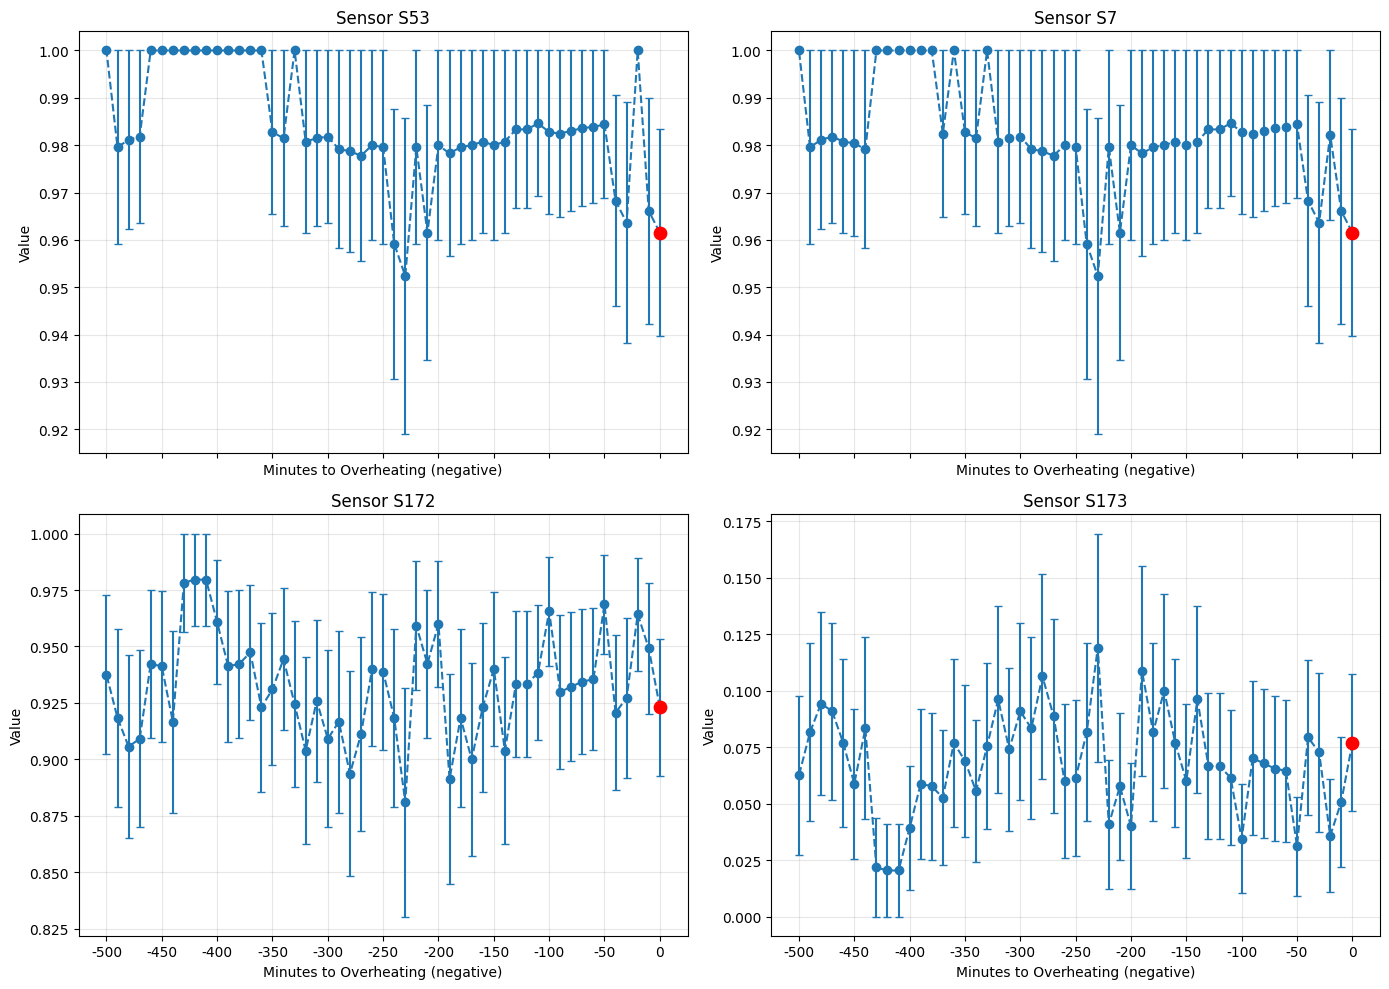

In [113]:
pdf = df_info_overheating.toPandas()
sensors = ["S53", "S7", "S172", "S173"]

# parametro step
step = 10
pdf = pdf.iloc[::step, :]
print(f"OCCHIO STO MOSTRANDO SOLO UN DATO OGNI {step}, PER MEGLIO CAPIRE GRAFICAMENTE")

# subplot 2x2
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()

for i, s in enumerate(sensors):
    ax = axes[i]
    
    # errorbar standard
    ax.errorbar(
        -pdf["MinToOverheating"],     
        pdf[f"{s}_avg"],
        yerr=pdf[f"{s}_err"],
        capsize=3,
        marker="o",
        linestyle="--",
        label=s
    )
    
    # evidenzia ultimo punto a destra in rosso
    last_idx = pdf["MinToOverheating"].idxmin()
    ax.scatter(
        -pdf.loc[last_idx, "MinToOverheating"],
        pdf.loc[last_idx, f"{s}_avg"],
        color="red",
        s=80,
        zorder=5,
        label="Ultimo punto"
    )
    
    ax.set_title(f"Sensor {s}")
    ax.set_xlabel("Minutes to Overheating (negative)")
    ax.set_ylabel("Value")
    ax.grid(True, alpha=0.3)

    # imposta tick asse x come valori negativi
    x_ticks = np.arange(int(-pdf["MinToOverheating"].max()), 1, 50)  # ogni 50 minuti
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([f"{int(x)}" for x in x_ticks])

plt.tight_layout()
plt.show()

## RandomTree (per singola variabile e poi combinato, sarebbe random forest ma vista step by step)

In [116]:
def get_best_threshold(df, feature, target):

    df = df.where( (col(target) == 1) | ((col(target) == 0) & (rand(seed=seed) <= 0.2)) )
    
    assembler = VectorAssembler(inputCols=[feature], outputCol="features")
    df_vec = assembler.transform(df)
    
    dt = DecisionTreeClassifier(featuresCol="features", labelCol=target, maxDepth=1)
    model = dt.fit(df_vec)
    
    # parsing dello split
    tree_str = model.toDebugString
    for line in tree_str.splitlines():
        if "<=" in line:
            try:
                return float(line.split("<= ")[1].split()[0])
            except:
                pass
    
    # fallback: media delle mediane
    medians = (
        df.groupBy(target)
          .agg(F.expr(f"percentile_approx({feature}, 0.5)").alias("median"))
          .toPandas()
    )
    if len(medians) == 2:
        return medians["median"].mean()
    else:
        return float(medians["median"].iloc[0])  # caso raro: solo una classe presente

In [117]:
def plot_histograms_with_threshold(df_spark, target_col, feature_cols, thresholds):
    pd_df = df_spark.select(target_col, *feature_cols).toPandas()
    
    for feature in feature_cols:
        fig, ax = plt.subplots(figsize=(8, 4))
        
        # histogram per classi
        for target_val, color in zip([0, 1], ["steelblue", "tomato"]):
            subset = pd_df[pd_df[target_col] == target_val]
            ax.hist(subset[feature], bins=30, alpha=0.5, color=color, 
                    label=f"{target_col}={target_val}", density=True)
        
        # soglia verticale tratteggiata (solo se esiste)
        thr = thresholds.get(feature, None)
        if thr is not None:
            ax.axvline(x=thr, color="black", linestyle="--", linewidth=2, label="Threshold")
        
        ax.set_ylabel("Density")
        ax.set_xlabel(feature)
        ax.legend()
        
        fig.suptitle(f"{feature}")
        plt.tight_layout()
        plt.show()

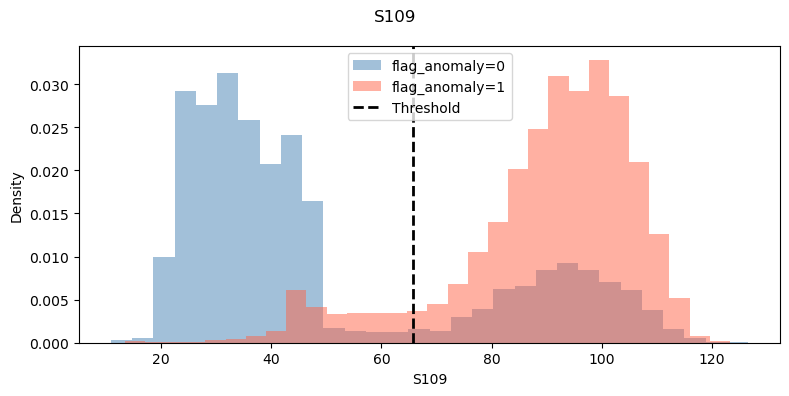

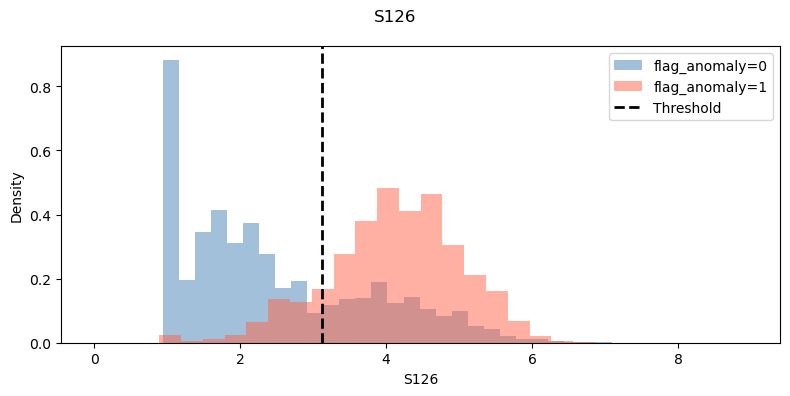

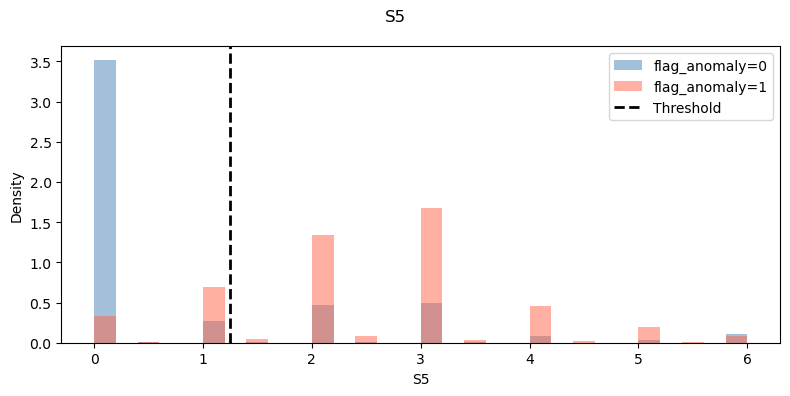

CPU times: user 491 ms, sys: 20 ms, total: 511 ms
Wall time: 1min 16s


In [118]:
%%time

thresholds = {}
for feature in ["S109","S126","S5"]:
    thr = get_best_threshold(df_final_088, feature, target="flag_anomaly")
    thresholds[feature] = thr

plot_histograms_with_threshold(df_final_088, "flag_anomaly", ["S109","S126","S5"], thresholds)

## SVM, Logistic, RandomForest

In [23]:
# ---------- Shared preprocessing ----------
def preprocess_features(df, feature_cols, scaler=True):
    df = df.where( (col(target) == 1) | ((col(target) == 0) & (rand(seed=123) <= 0.2)) )
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    df_feat = assembler.transform(df).select(*feature_cols, *[c for c in df.columns if c not in feature_cols], "features")
    if not scaler:
        return df_feat, None
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
    scaler_model = scaler.fit(df_feat)
    df_scaled = scaler_model.transform(df_feat)
    return df_scaled, scaler_model

# ---------- Replicate positives for RF ----------
def replicate_positive(df, label_col, n_rep):
    n_rep = int(n_rep)
    if n_rep <= 1:
        return df
    df_w = df.withColumn("_rep", when(col(label_col) == 1, lit(n_rep)).otherwise(lit(1)))
    df_rep = df_w.withColumn("_dup", explode(array_repeat(lit(1), col("_rep")))).drop("_rep", "_dup")
    return df_rep

# ---------- Add weight column for linear models ----------
def add_class_weights(df, label_col, weight_class1):
    return df.withColumn("weight", when(col(label_col) == 1, lit(float(weight_class1))).otherwise(lit(1.0)))

# ---------- SVM runner ----------
def svm(f_data, top_corr_alarm, target, weight_class1=1.0, seed=516622):
    df = f_data.select(*top_corr_alarm, target)
    df_prep, scaler_model = preprocess_features(df, top_corr_alarm, scaler=True)
    df_prep = add_class_weights(df_prep, target, weight_class1)
    train, _ = df_prep.randomSplit([0.8, 0.2], seed=seed)
    svc = LinearSVC(featuresCol="scaledFeatures", labelCol=target, weightCol="weight",
                    rawPredictionCol="rawPrediction", predictionCol="prediction",
                    regParam=0.01, maxIter=1000, tol=1e-8)
    model = svc.fit(train)
    preds = model.transform(df_prep)                          # predict on full (original) df_data
    cm = get_confusion_matrix(preds, target)
    plot_confusion_heatmap(cm, target)
    metrics = calculate_metrics(preds, cm, target)
    return {"model": model, "predictions": preds, "cm": cm, "metrics": metrics, "scaler": scaler_model}

# ---------- Logistic runner ----------
def logistic(f_data, top_corr_alarm, target, weight_class1=1.0, seed=516622):
    df = f_data.select(*top_corr_alarm, target)
    df_prep, scaler_model = preprocess_features(df, top_corr_alarm, scaler=True)
    df_prep = add_class_weights(df_prep, target, weight_class1)
    train, _ = df_prep.randomSplit([0.8, 0.2], seed=seed)
    lr = LogisticRegression(featuresCol="scaledFeatures", labelCol=target, weightCol="weight",
                            rawPredictionCol="rawPrediction", predictionCol="prediction")
    model = lr.fit(train)
    preds = model.transform(df_prep)
    cm = get_confusion_matrix(preds, target)
    plot_confusion_heatmap(cm, target)
    metrics = calculate_metrics(preds, cm, target)
    return {"model": model, "predictions": preds, "cm": cm, "metrics": metrics, "scaler": scaler_model}

# ---------- Random Forest runner (replicate class-1) ----------
def random_forest(f_data, top_corr_alarm, target, weight_class1=1.0, n_trees=100, max_depth=10, seed=42):
    df = f_data.select(*top_corr_alarm, target)
    rep_n = max(1, int(floor(weight_class1)))   # number of copies per positive
    df_rep = replicate_positive(df, target, rep_n)
    df_prep, _ = preprocess_features(df_rep, top_corr_alarm, scaler=False)  # RF uses raw features
    train, _ = df_prep.randomSplit([0.8, 0.2], seed=seed)
    rf = RandomForestClassifier(featuresCol="features", labelCol=target, rawPredictionCol="rawPrediction", predictionCol="prediction",
                                numTrees=n_trees, maxDepth=max_depth, seed=seed)
    model = rf.fit(train)
    # feature importances
    rf_model = model
    importances = rf_model.featureImportances.toArray()
    feature_importance = sorted(zip(top_corr_alarm, importances), key=lambda x: -x[1])
    # predict on original full (non-replicated) data preprocessed the same way
    df_orig_prep, _ = preprocess_features(df, top_corr_alarm, scaler=False)
    preds = model.transform(df_orig_prep)
    cm = get_confusion_matrix(preds, target)
    plot_confusion_heatmap(cm, target)
    metrics = calculate_metrics(preds, cm, target)
    return {"model": model, "predictions": preds, "cm": cm, "metrics": metrics, "feature_importance": feature_importance}

# --------------------
def get_confusion_matrix(df_predictions, target):
    cm_data = df_predictions.groupBy(target, "prediction").count().collect()
    cm_dict = {(row[target], row["prediction"]): row['count'] for row in cm_data}   
    tn = cm_dict.get((0, 0), 0)
    fp = cm_dict.get((0, 1), 0)  
    fn = cm_dict.get((1, 0), 0)
    tp = cm_dict.get((1, 1), 0)
    return pd.DataFrame([[tn, fp], [fn, tp]], 
                       index=['Actual_0', 'Actual_1'],
                       columns=['Pred_0', 'Pred_1'])

# --------------------
def plot_confusion_heatmap(cm_pandas, target):
    plt.figure(figsize=(4,4))
    sns.heatmap(cm_pandas, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.show()

# --------------------
def calculate_metrics(df_predictions, cm_pandas, target):
    tn, fp = cm_pandas.iloc[0]
    fn, tp = cm_pandas.iloc[1]
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol=target)
    auc = evaluator.evaluate(df_predictions)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    return {'accuracy': accuracy, 'precision': precision, 'auc': auc}

In [24]:
df = df_final_088
#top_corr_alarm = ["S109","S9","S126"]
top_corr_alarm = ["S7","S53","SA3","S8","S172","S173","S39","S40","S3","P2"] # per "predictive_overheating"
target = "predictive_overheating"
df_data = df.select(*top_corr_alarm,"overheating","predictive_overheating","flag_anomaly","predictive_flag_anomaly")

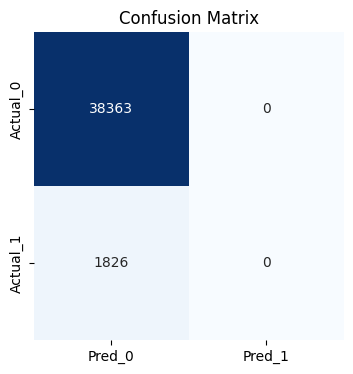

{'model': LinearSVCModel: uid=LinearSVC_4b8a36bab72f, numClasses=2, numFeatures=10,
 'predictions': DataFrame[S7: int, S53: int, SA3: int, S8: int, S172: int, S173: int, S39: double, S40: double, S3: double, P2: int, predictive_overheating: int, features: vector, scaledFeatures: vector, weight: double, rawPrediction: vector, prediction: double],
 'cm':           Pred_0  Pred_1
 Actual_0   38363       0
 Actual_1    1826       0,
 'metrics': {'accuracy': 0.9545646818781258,
  'precision': 0,
  'auc': 0.7875136054760686},
 'scaler': StandardScalerModel: uid=StandardScaler_042690ce2e29, numFeatures=10, withMean=true, withStd=true}

In [25]:
# --------- SVM ---------
svm(df_data, top_corr_alarm, target, weight_class1=1)

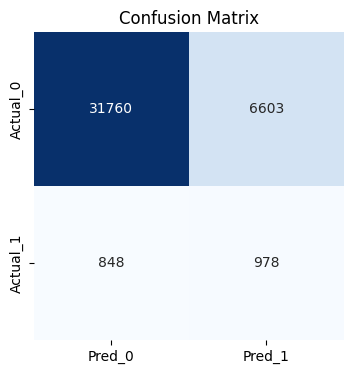

{'model': LogisticRegressionModel: uid=LogisticRegression_46c0d38a8bdd, numClasses=2, numFeatures=10,
 'predictions': DataFrame[S7: int, S53: int, SA3: int, S8: int, S172: int, S173: int, S39: double, S40: double, S3: double, P2: int, predictive_overheating: int, features: vector, scaledFeatures: vector, weight: double, rawPrediction: vector, probability: vector, prediction: double],
 'cm':           Pred_0  Pred_1
 Actual_0   31760    6603
 Actual_1     848     978,
 'metrics': {'accuracy': 0.814601010226679,
  'precision': 0.1290067273446775,
  'auc': 0.8146936729008153},
 'scaler': StandardScalerModel: uid=StandardScaler_4edbd948ee0b, numFeatures=10, withMean=true, withStd=true}

In [83]:
# --------- Logistic Regression ---------
logistic(df_data, top_corr_alarm, target, weight_class1=10)

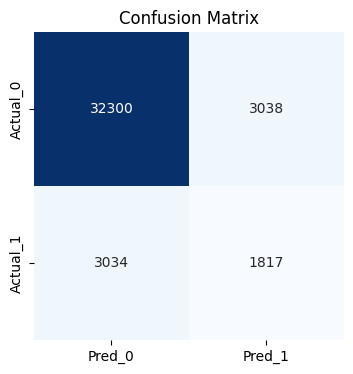

{'model': RandomForestClassificationModel: uid=RandomForestClassifier_69a74bb52f4c, numTrees=120, numClasses=2, numFeatures=10,
 'predictions': DataFrame[S7: int, S53: int, SA3: int, S8: int, S172: int, S173: int, S39: double, S40: double, S3: double, P2: int, flag_anomaly: int, features: vector, rawPrediction: vector, probability: vector, prediction: double],
 'cm':           Pred_0  Pred_1
 Actual_0   32300    3038
 Actual_1    3034    1817,
 'metrics': {'accuracy': 0.8489138819079848,
  'precision': 0.37425334706488156,
  'auc': 0.8120976927482267},
 'feature_importance': [('S40', 0.30019744370502005),
  ('S39', 0.2680522932556867),
  ('S3', 0.19732798591229256),
  ('S173', 0.08833664652623784),
  ('S172', 0.056383266336913526),
  ('S7', 0.036772209237197775),
  ('S53', 0.03139147480594331),
  ('S8', 0.010916806737363154),
  ('SA3', 0.009671730814711824),
  ('P2', 0.0009501426686332813)]}

In [40]:
# --------- Random Forest ---------
random_forest(df_data, top_corr_alarm, "flag_anomaly", weight_class1=3, n_trees=120, max_depth=5)